In [24]:
# standard libs
import os
import sys
import logging
import itertools
import matplotlib.pyplot as plt

# project lib
PROJECT_SRC_PATH = os.path.join(os.path.abspath(''), '..', 'src')
sys.path.append(PROJECT_SRC_PATH)

import visualizations
from prediction_age import AgePredictor, AgeClassifier, AgePredictorComparison
from prediction_type import TypeClassifier, TypeClassifierComparison
import preprocessing as pp
import dataset

# external libs
import numpy as np
import pandas as pd
import geopandas as gpd
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
%load_ext autoreload
%autoreload 2

## Data

Demo sample of ~20k buildings for Spain, ~50k for France, and 170k for the Netherlands. All 117 urban form features, lat lon, as well as some auxiliary attributes like city name, neighborhood, building type, etc. are included.

The demo samples are stored using Git Large File Storage (LFS). To download them explicitly use:

In [4]:
!git lfs pull

In [5]:
DATA_DIR = os.path.join('.')

path_data_NLD = os.path.join(DATA_DIR, 'df-NLD-exp.pkl')
path_data_FRA = os.path.join(DATA_DIR, 'df-FRA-exp.pkl')
path_data_ESP = os.path.join(DATA_DIR, 'df-ESP-exp.pkl')

df_fra = pd.read_pickle(path_data_FRA)
df_fra['country'] = 'France'
df_nld = pd.read_pickle(path_data_NLD)
df_nld['country'] = 'Netherlands'
df_esp = pd.read_pickle(path_data_ESP)
df_esp['country'] = 'Spain'
df_fra.head(3)

source_file  dist_to_closest_int  \
70759  BATIMENT-hauts-de-france            55.892708   
70760  BATIMENT-hauts-de-france           140.890261   
70761  BATIMENT-hauts-de-france            65.441049   

       av_footprint_area_within_buffer_100  \
70759                            83.863552   
70760                            87.522566   
70761                           103.774050   

       street_betweeness_global_max_within_buffer_500  \
70759                                        0.077524   
70760                                        0.070352   
70761                                        0.143455   

       av_elongation_within_buffer_500                         geometry  \
70759                         0.610599  POINT (3835303.634 3045749.519)   
70760                         0.618166  POINT (3835488.284 3045958.224)   
70761                         0.594590  POINT (3838070.711 3043651.916)   

       std_building_footprint_city     block  blocks_2_to_4  \
70759                   209.353513  b3fdc454         2515.0   
70760                   209.353513  897496cb         2515.0   
70761                   209.353513  36468125         2515.0   

       street_closeness_500_av_within_buffer_500  ...  TouchesIndexes  \
70759                                   0.000018  ...             [0]   
70760                                   0.000016  ...             [1]   
70761                                   0.000038  ...            [12]   

       street_based_block_av_phi_inter_buffer_500  total_length_street_city  \
70759                                    0.380861             431666.030876   
70760                                    0.369534             431666.030876   
70761                                    0.431410             431666.030876   

       total_buildings_footprint_city       Phi  \
70759                    1.698346e+06  0.614581   
70760                    1.698346e+06  0.524436   
70761                    1.698346e+06  0.533688   

       street_based_block_std_area_inter_buffer_100             type  \
70759                                  2.875896e+06      residential   
70760                                  3.258351e+06  non-residential   
70761                                  2.296982e+06  non-residential   

       neighborhood  n_neighbors  residential_type  
70759      58148666            1               SFH  
70760      58148666            1               NaN  
70761      28e97cb2            1               NaN  

[3 rows x 138 columns]

## Experiments
The evaluation protocol explicitly evaluates distribution shift based on 3 types of train/test splits as follows. The evaluation protocols are based on Beery et al. (2022). 

- **Per-country Splits**: Investigates how well a country generalizes to itself. Here, each country has a defined training region and a defined test region, split by city. The test sets for each country are never used for training.
- **Cross-country Generalization**: Examines how effective it would be to train on country A if we are interested in testing on country B. For this analysis, we first perform all possible cross training combinations, training on every train split per country and testing each model on the test set for each country. Results for these pairwise combinations are then visualized.
- **Full Dataset**: For the final and largest split, we combine training data across all countries. We then test on the test sets of all countries.

**References**:
- Beery, Sara, et al. "The Auto Arborist Dataset: A Large-Scale Benchmark for Multiview Urban Forest Monitoring Under Domain Shift." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2022.

In [6]:
import random
random.seed(dataset.GLOBAL_REPRODUCIBILITY_SEED)

df = pd.concat([df_fra, df_nld, df_esp])
config = {country: dict() for country in df.country.unique()}

n = 7
for country in config:
    country_df = df[df['country'] == country]
    city_list = list(country_df['city'].unique())
    train_list = random.sample(city_list, n)
    test_list = list(set(city_list) - set(train_list))
    config[country]['train'] = train_list
    config[country]['test'] = test_list
config

{'France': {'train': ['Lescar',
   "L'Île-d'Yeu",
   'Mortrée',
   'Arleux',
   'Montauban',
   'Niolu-Omessa',
   'Ribiers'],
  'test': ['Oullins', 'Saint-Ciers-sur-Gironde', 'Royat']},
 'Netherlands': {'train': ['Kapelle',
   'Groesbeek',
   'Dinxperlo',
   'Rijnwaarden',
   'Apeldoorn',
   'Roggel en Neer',
   'IJsselstein'],
  'test': ['Dronten', 'Jacobswoude', 'Renkum']},
 'Spain': {'train': ['Veciana',
   'Aldehuela de Yeltes',
   'Torre-serona',
   'Montclar',
   'Rublacedo de Abajo',
   'Llíria',
   'Trujillanos'],
  'test': ['Piera', 'San Martín del Castañar', 'Quintanilla de la Mata']}}

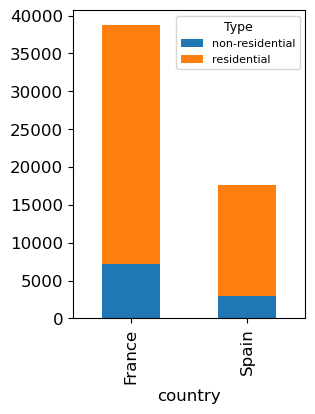

In [34]:
train_data = []
for country in config:
    train_data.append(df[df.city.isin(config[country]['train'])])
train_data = pd.concat(train_data)

train_data_type = train_data[train_data['type'] != 'unknown']
crosstab = pd.crosstab(index=train_data_type['country'], columns=train_data_type['type'])
crosstab.plot(kind='bar', stacked=True, figsize=(3,4))
plt.legend(title='Type', title_fontsize=9, prop={'size': 8});

#### Default params

In [7]:
xgb_model_params = {'tree_method': 'hist'}
xgb_hyperparams = {
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 500,
    'colsample_bytree': 0.5,
    'subsample': 1.0,
}

In [8]:
def get_cross_country_split(df, config, test_country, train_country=None):
    if train_country is None:
        train = []
        for country in config:
            train.append(df[df.city.isin(config[country]['train'])])
        train = pd.concat(train)
    else:
        train = df[df.city.isin(config[train_country]['train'])]
    test = df[df.city.isin(config[test_country]['test'])]
    return train, test

### Building Type Classification

#### Per-country Splits

Train: France Test: France


2022-11-27 12:39:09,020 | INFO : Dataset length: 71090
2022-11-27 12:39:09,025 | INFO : Dataset allocated memory: 75 MB
2022-11-27 12:39:09,059 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-b77d8613.abort.
2022-11-27 12:39:09,059 | INFO : Training dataset length: 38738
2022-11-27 12:39:09,059 | INFO : Test dataset length: 10417
2022-11-27 12:39:09,061 | INFO : Test cities: ['Oullins' 'Royat' 'Saint-Ciers-sur-Gironde']
2022-11-27 12:39:09,244 | INFO : Training dataset length after preprocessing: 38738
2022-11-27 12:39:09,244 | INFO : Test dataset length after preprocessing: 10417
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Classification report:
                  precision    recall  f1-score  support
residential       0.901641  0.962790  0.931213     8788
non-residential   0.683446  0.433395  0.530428     1629
accuracy          0.880004  0.880004  0.880004        0
macro avg         0.792544  0.698092  0.730821    10417
weighted avg      0.867520  0.880004  0.868539    10417
Cohen’s kappa: 0.4656
Matthews correlation coefficient (MCC): 0.4815


FixedFormatter should only be used together with FixedLocator


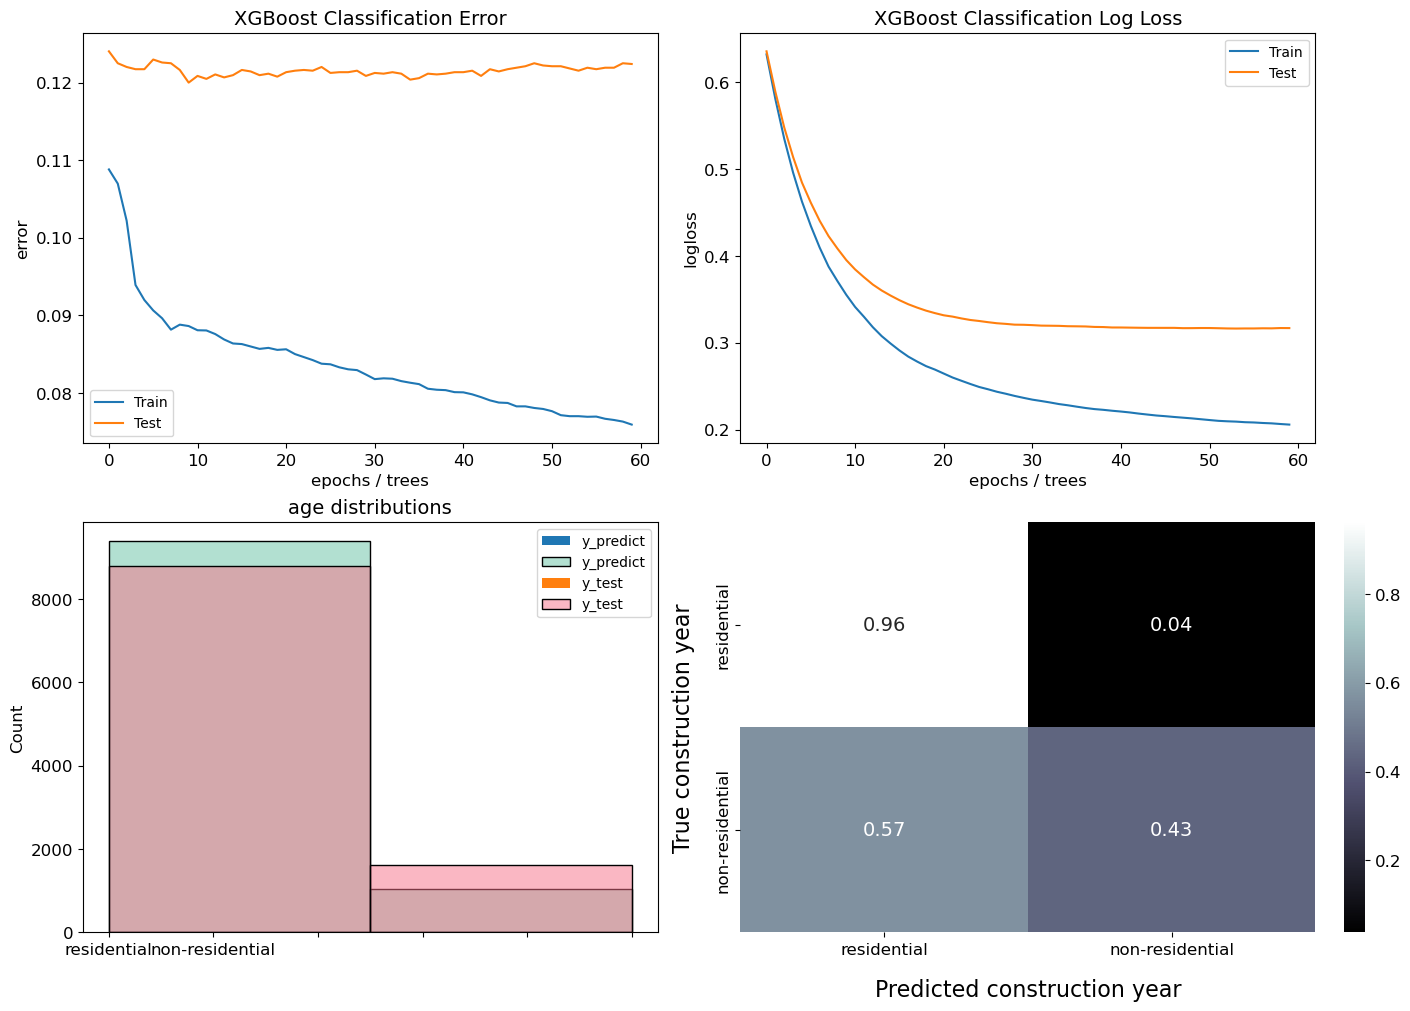

Train: Spain Test: Spain


2022-11-27 12:39:11,316 | INFO : Dataset length: 71090
2022-11-27 12:39:11,322 | INFO : Dataset allocated memory: 75 MB
2022-11-27 12:39:11,339 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-9a81694d.abort.
2022-11-27 12:39:11,340 | INFO : Training dataset length: 17673
2022-11-27 12:39:11,340 | INFO : Test dataset length: 4262
2022-11-27 12:39:11,341 | INFO : Test cities: ['Piera' 'Quintanilla de la Mata' 'San Martín del Castañar']
2022-11-27 12:39:11,429 | INFO : Training dataset length after preprocessing: 17666
2022-11-27 12:39:11,430 | INFO : Test dataset length after preprocessing: 4253
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Classification report:
                  precision    recall  f1-score  support
residential       0.928571  0.988108  0.957415     3868
non-residential   0.664234  0.236364  0.348659      385
accuracy          0.920056  0.920056  0.920056        0
macro avg         0.796403  0.612236  0.653037     4253
weighted avg      0.904642  0.920056  0.902308     4253
Cohen’s kappa: 0.3162
Matthews correlation coefficient (MCC): 0.3648


FixedFormatter should only be used together with FixedLocator


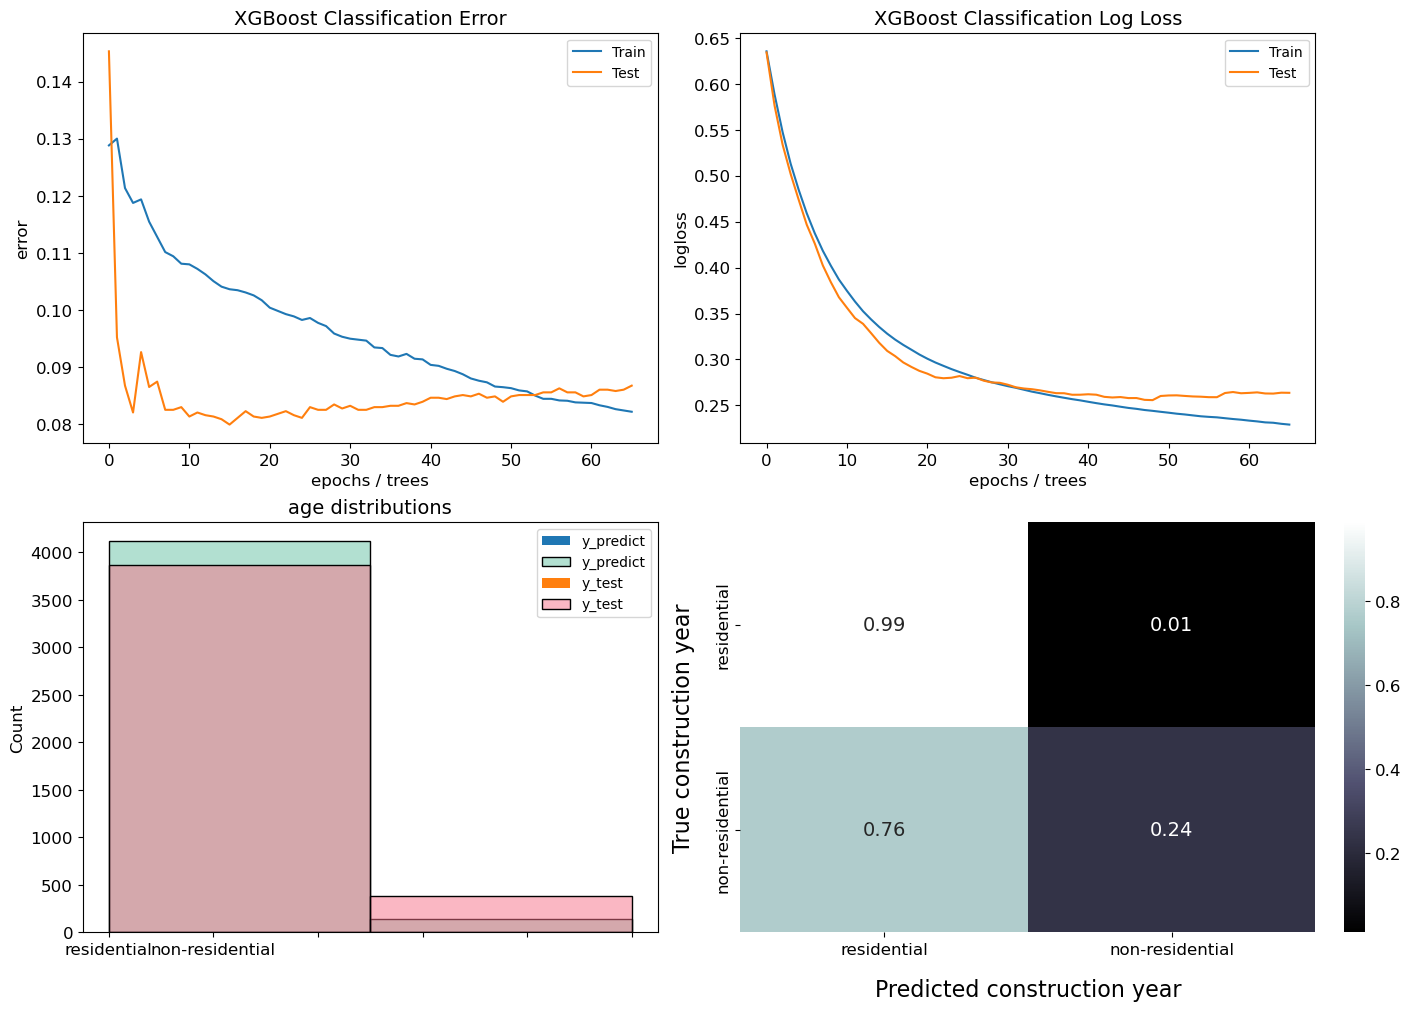

In [35]:
for country in ['France', 'Spain']:
    print(f"Train: {country} Test: {country}")
    test_training_split = lambda df: get_cross_country_split(
        df, config=config, test_country=country, train_country=country
    )
    predictor = TypeClassifier(
        model=XGBClassifier(**xgb_model_params),
        labels=['residential', 'non-residential'],
        df=df.copy(),
        test_training_split=test_training_split,
        validate_labels=False,
        early_stopping=True,
        preprocessing_stages=[],
        hyperparameters=xgb_hyperparams
    )
    predictor.evaluate()

In [39]:
print(list(predictor.X_test.columns))

['dist_to_closest_int', 'av_footprint_area_within_buffer_100', 'street_betweeness_global_max_within_buffer_500', 'av_elongation_within_buffer_500', 'std_building_footprint_city', 'blocks_2_to_4', 'street_closeness_500_av_within_buffer_500', 'street_width_std_within_buffer_100', 'av_footprint_area_within_buffer_500', 'street_length_total_within_buffer_500', 'BlockConvexity', 'buildings_within_buffer_500', 'StdBlockFootprintArea', 'street_closeness_global_closest_street', 'std_block_footprint_area_within_buffer_100', 'street_based_block_std_orientation_inter_buffer_100', 'street_length_std_within_buffer_100', 'AvBlockFootprintArea', 'std_block_length_within_buffer_100', 'street_betweeness_global_av_within_buffer_500', 'street_based_block_std_area_inter_buffer_500', 'street_length_closest_street', 'Elongation', 'BlockLength', 'street_closeness_500_closest_street', 'street_length_total_within_buffer_100', 'street_based_block_number_inter_buffer_100', 'street_length_av_within_buffer_500', '

#### Cross-country Generalization

2022-11-27 11:41:32,474 | INFO : Dataset length: 71090


Train: France Test: Spain


2022-11-27 11:41:32,482 | INFO : Dataset allocated memory: 75 MB
2022-11-27 11:41:32,506 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-0cd74481.abort.
2022-11-27 11:41:32,506 | INFO : Training dataset length: 38738
2022-11-27 11:41:32,507 | INFO : Test dataset length: 4262
2022-11-27 11:41:32,508 | INFO : Test cities: ['Piera' 'Quintanilla de la Mata' 'San Martín del Castañar']
2022-11-27 11:41:32,672 | INFO : Training dataset length after preprocessing: 38738
2022-11-27 11:41:32,673 | INFO : Test dataset length after preprocessing: 4253
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Classification report:
                  precision    recall  f1-score  support
residential       0.916314  0.727508  0.811068     3868
non-residential   0.108291  0.332468  0.163369      385
accuracy          0.691747  0.691747  0.691747        0
macro avg         0.512302  0.529988  0.487219     4253
weighted avg      0.843168  0.691747  0.752435     4253
Cohen’s kappa: 0.0310
Matthews correlation coefficient (MCC): 0.0384


FixedFormatter should only be used together with FixedLocator


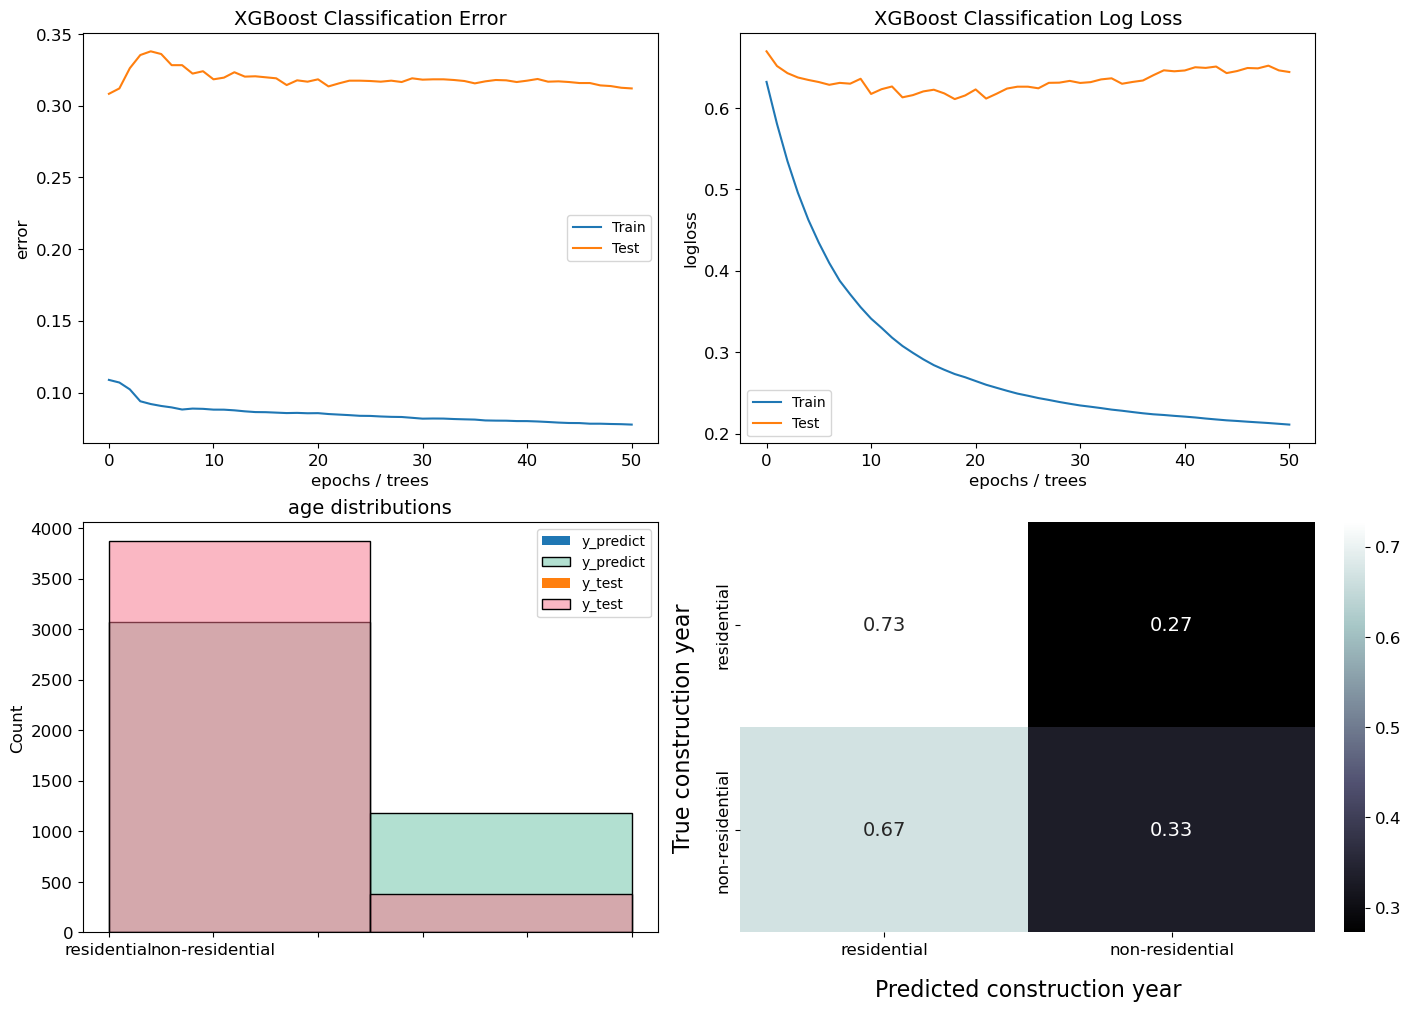

2022-11-27 11:41:34,546 | INFO : Dataset length: 71090


Train: Spain Test: France


2022-11-27 11:41:34,554 | INFO : Dataset allocated memory: 75 MB
2022-11-27 11:41:34,573 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-110d4297.abort.
2022-11-27 11:41:34,574 | INFO : Training dataset length: 17673
2022-11-27 11:41:34,575 | INFO : Test dataset length: 10417
2022-11-27 11:41:34,576 | INFO : Test cities: ['Oullins' 'Royat' 'Saint-Ciers-sur-Gironde']
2022-11-27 11:41:34,680 | INFO : Training dataset length after preprocessing: 17666
2022-11-27 11:41:34,680 | INFO : Test dataset length after preprocessing: 10417
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Classification report:
                  precision    recall  f1-score  support
residential       0.847936  0.970187  0.904951     8788
non-residential   0.276243  0.061387  0.100452     1629
accuracy          0.828070  0.828070  0.828070        0
macro avg         0.562090  0.515787  0.502702    10417
weighted avg      0.758536  0.828070  0.779145    10417
Cohen’s kappa: 0.0462
Matthews correlation coefficient (MCC): 0.0626


FixedFormatter should only be used together with FixedLocator


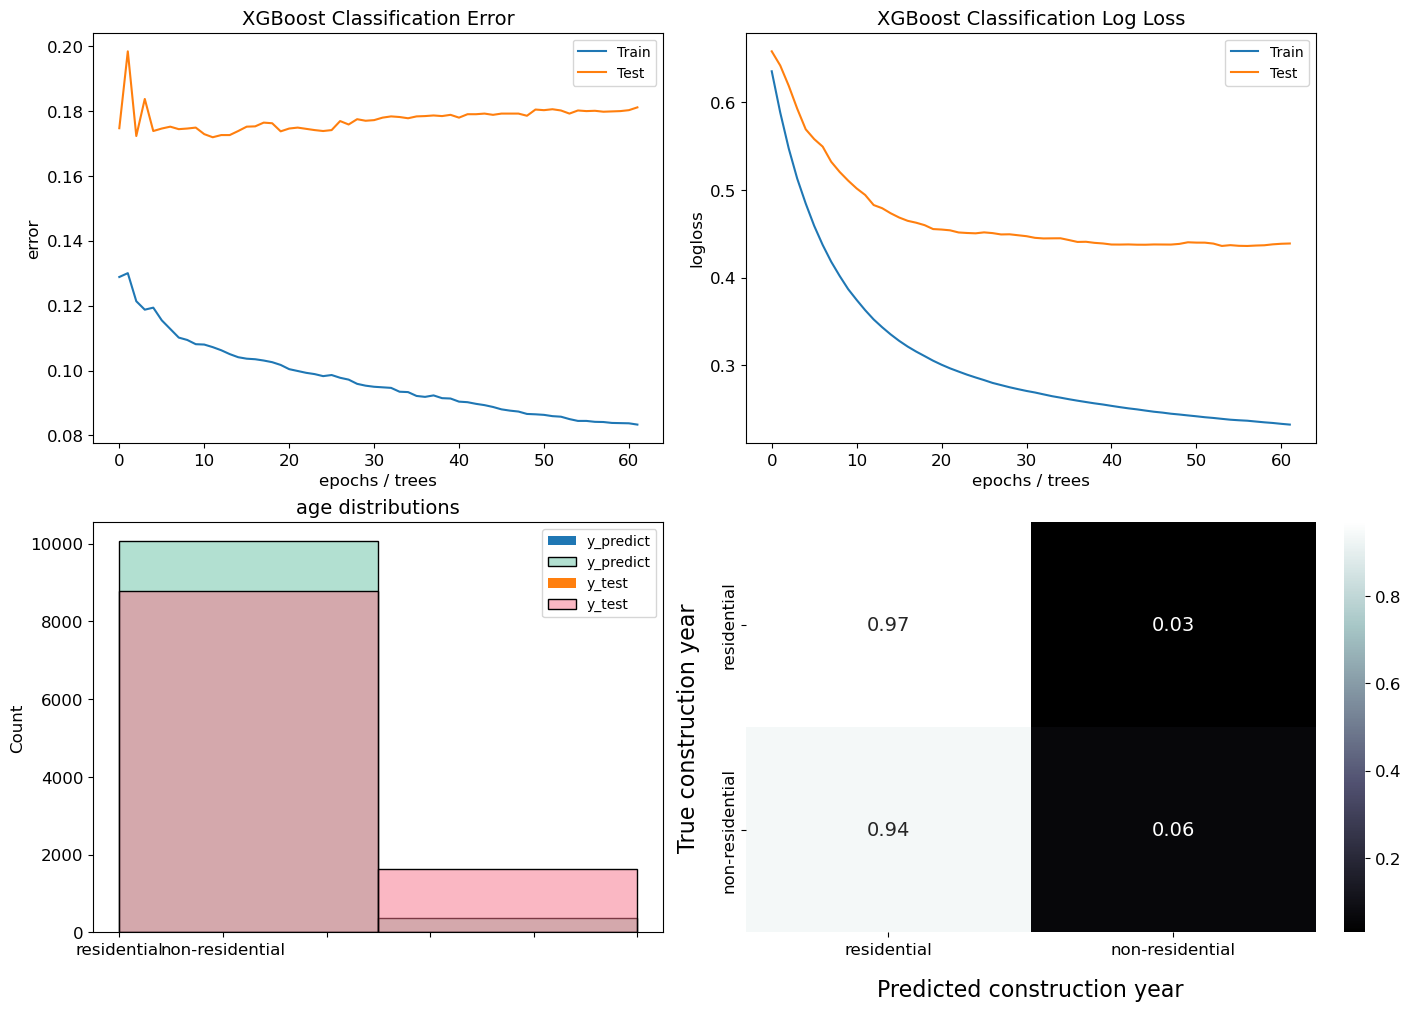

In [10]:
for train_country, test_country in itertools.permutations(['France', 'Spain'], 2):
    print(f"Train: {train_country} Test: {test_country}")
    test_training_split = lambda df: get_cross_country_split(
        df, config=config, test_country=test_country, train_country=train_country
    )
    predictor = TypeClassifier(
        model=XGBClassifier(**xgb_model_params),
        labels=['residential', 'non-residential'],
        df=df.copy(),
        test_training_split=test_training_split,
        validate_labels=False,
        early_stopping=True,
        preprocessing_stages=[],
        hyperparameters=xgb_hyperparams
    )
    predictor.evaluate()

### Full Dataset

2022-11-27 11:41:36,516 | INFO : Dataset length: 71090


Train: ['France', 'Spain'] Test: France


2022-11-27 11:41:36,523 | INFO : Dataset allocated memory: 75 MB
2022-11-27 11:41:36,616 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-52bba8ab.abort.
2022-11-27 11:41:36,617 | INFO : Training dataset length: 56411
2022-11-27 11:41:36,617 | INFO : Test dataset length: 10417
2022-11-27 11:41:36,618 | INFO : Test cities: ['Oullins' 'Royat' 'Saint-Ciers-sur-Gironde']
2022-11-27 11:41:36,897 | INFO : Training dataset length after preprocessing: 56404
2022-11-27 11:41:36,897 | INFO : Test dataset length after preprocessing: 10417
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Classification report:
                  precision    recall  f1-score  support
residential       0.905017  0.960628  0.931994     8788
non-residential   0.682277  0.456108  0.546726     1629
accuracy          0.881732  0.881732  0.881732        0
macro avg         0.793647  0.708368  0.739360    10417
weighted avg      0.870185  0.881732  0.871746    10417
Cohen’s kappa: 0.4818
Matthews correlation coefficient (MCC): 0.4947


FixedFormatter should only be used together with FixedLocator


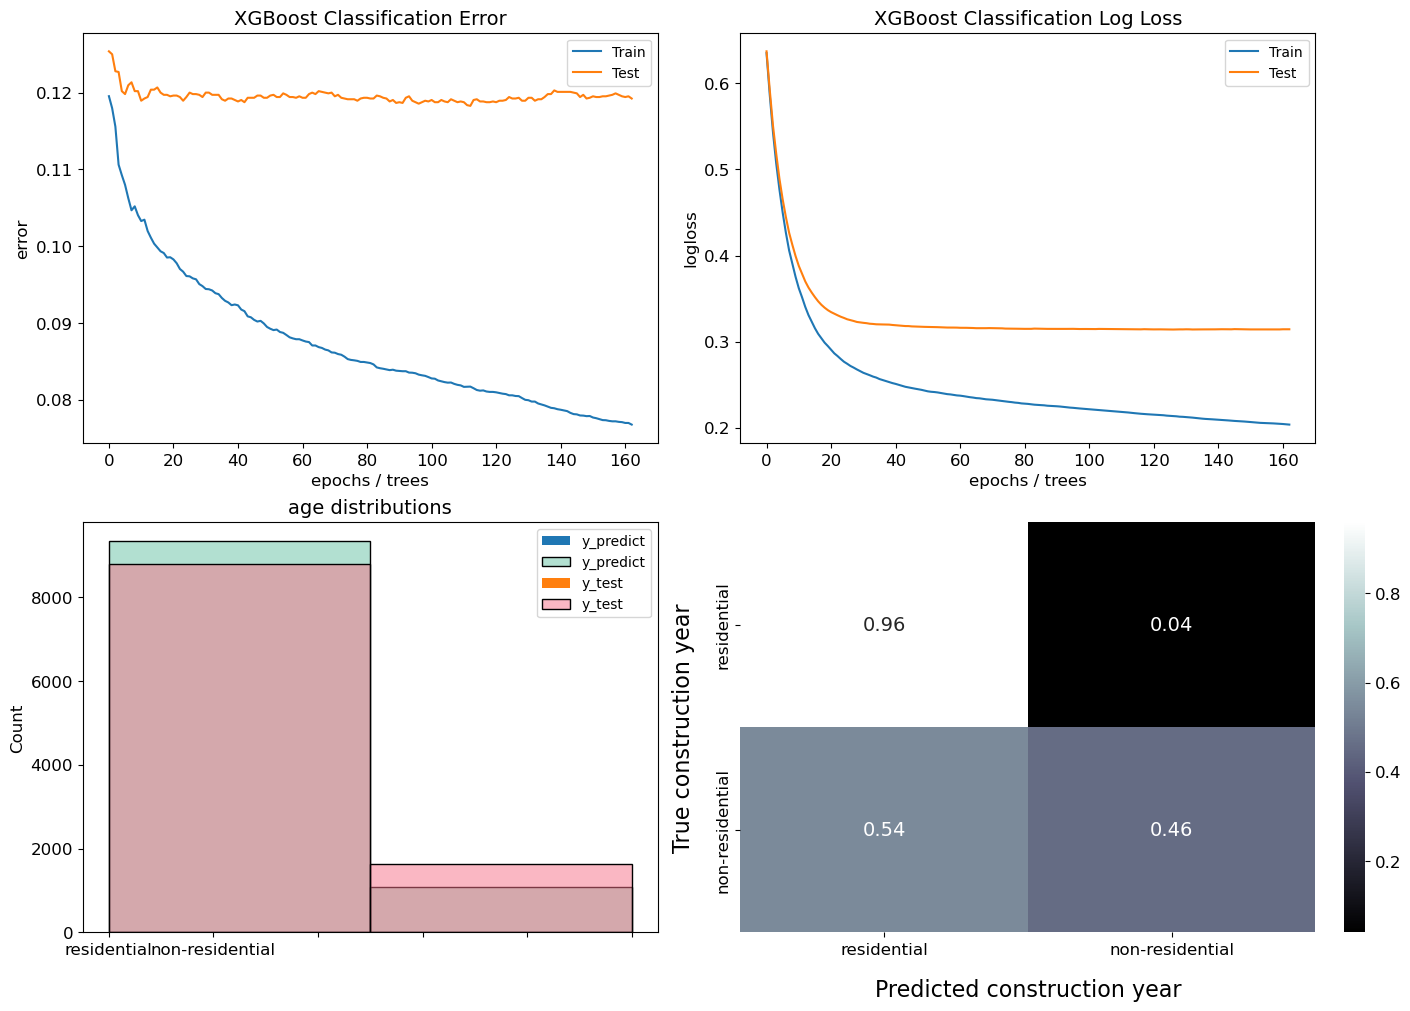

2022-11-27 11:41:40,589 | INFO : Dataset length: 71090


Train: ['France', 'Spain'] Test: Spain


2022-11-27 11:41:40,596 | INFO : Dataset allocated memory: 75 MB
2022-11-27 11:41:40,690 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-71295739.abort.
2022-11-27 11:41:40,691 | INFO : Training dataset length: 56411
2022-11-27 11:41:40,691 | INFO : Test dataset length: 4262
2022-11-27 11:41:40,692 | INFO : Test cities: ['Piera' 'Quintanilla de la Mata' 'San Martín del Castañar']
2022-11-27 11:41:40,950 | INFO : Training dataset length after preprocessing: 56404
2022-11-27 11:41:40,951 | INFO : Test dataset length after preprocessing: 4253
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Classification report:
                  precision    recall  f1-score  support
residential       0.923299  0.992761  0.956771     3868
non-residential   0.702128  0.171429  0.275574      385
accuracy          0.918411  0.918411  0.918411        0
macro avg         0.812713  0.582095  0.616173     4253
weighted avg      0.903277  0.918411  0.895106     4253
Cohen’s kappa: 0.2489
Matthews correlation coefficient (MCC): 0.3205


FixedFormatter should only be used together with FixedLocator


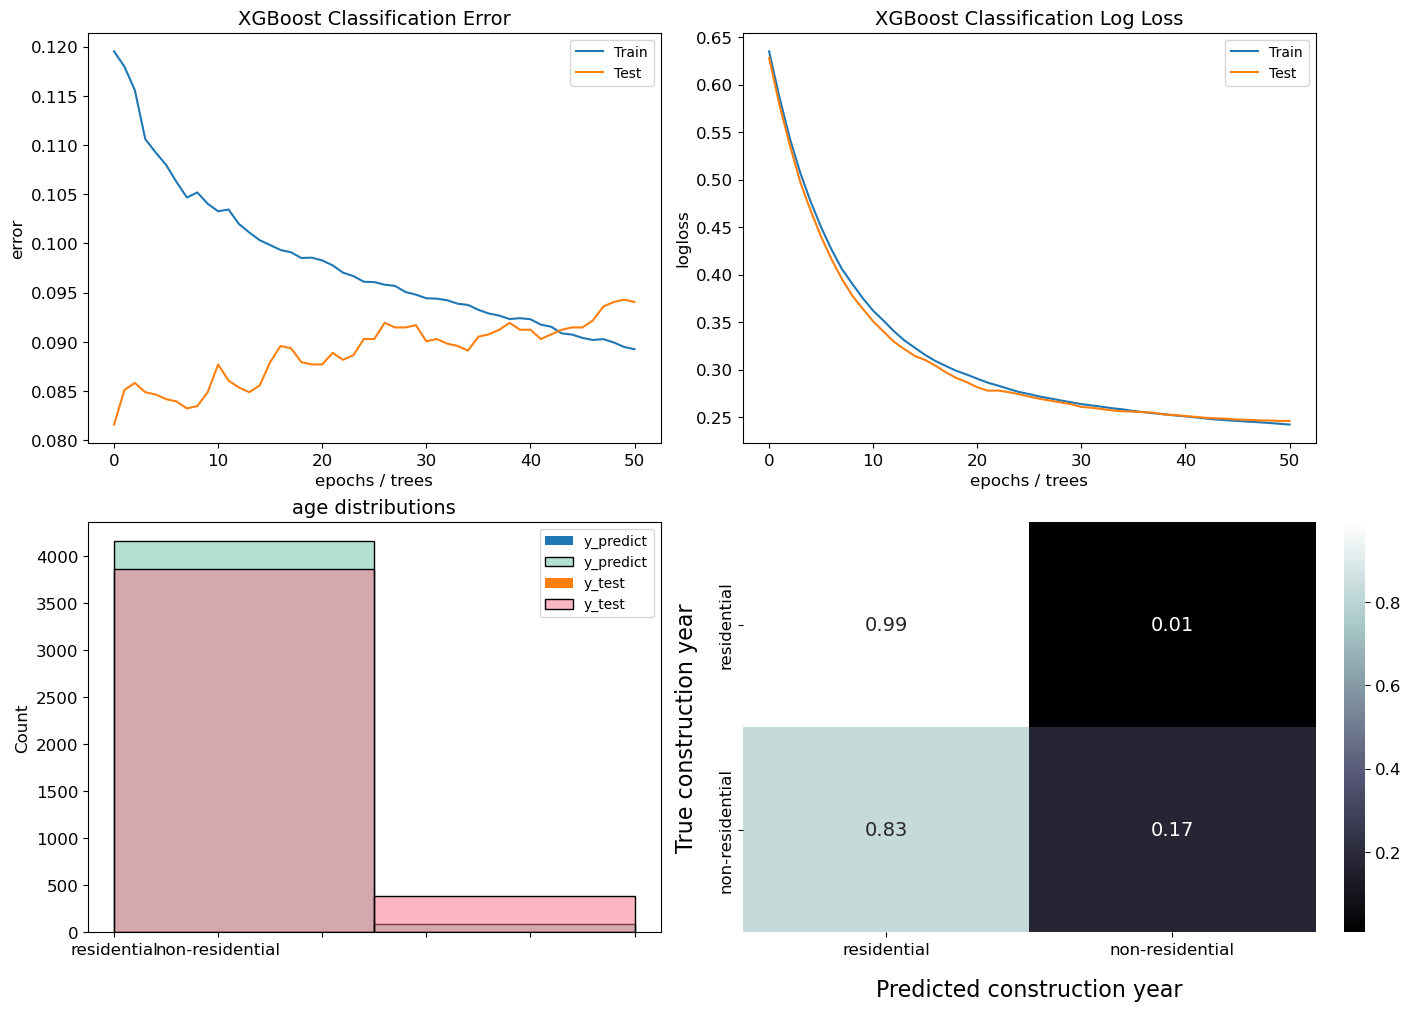

In [11]:
for country in ['France', 'Spain']:
    print(f"Train: {['France', 'Spain']} Test: {country}")
    test_training_split = lambda df: get_cross_country_split(
        df, config=config, test_country=country
    )
    predictor = TypeClassifier(
        model=XGBClassifier(**xgb_model_params),
        labels=['residential', 'non-residential'],
        df=df.copy(),
        test_training_split=test_training_split,
        validate_labels=False,
        early_stopping=True,
        preprocessing_stages=[],
        hyperparameters=xgb_hyperparams
    )
    predictor.evaluate()

### Building Age Predicition (Regression)

#### Per-country Splits

Train: France Test: France


2022-11-27 11:41:43,379 | INFO : Dataset length: 247520
2022-11-27 11:41:43,388 | INFO : Dataset allocated memory: 262 MB
2022-11-27 11:41:43,425 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-5c20072e.abort.
2022-11-27 11:41:43,428 | INFO : Dataset standard deviation: 39.92809523509025
2022-11-27 11:41:43,430 | INFO : Dataset mean age: 1969.9830761150615
2022-11-27 11:41:43,430 | INFO : Training dataset length: 38842
2022-11-27 11:41:43,431 | INFO : Test dataset length: 10424
2022-11-27 11:41:43,555 | INFO : Test dataset standard deviation after preprocessing: 25.85459271143312
2022-11-27 11:41:43,556 | INFO : Test dataset mean age after preprocessing: 1979.240777809551
2022-11-27 11:41:43,557 | INFO : Training dataset length after preprocessing: 31742
2022-11-27 11:41:43,558 | INFO : Test dataset length after preprocessing: 6994
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with sciki

MAE: 18.82 y
RMSE: 24.67 y
R2: 0.0893
R2: nan
MAPE: nan


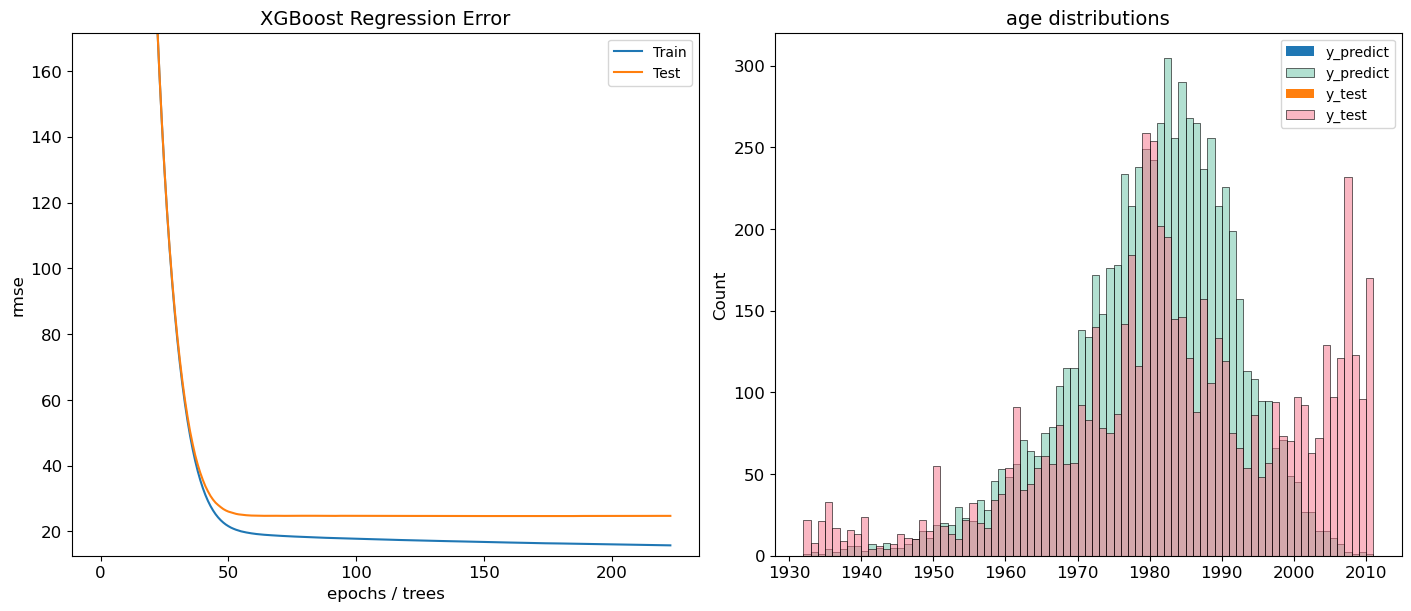

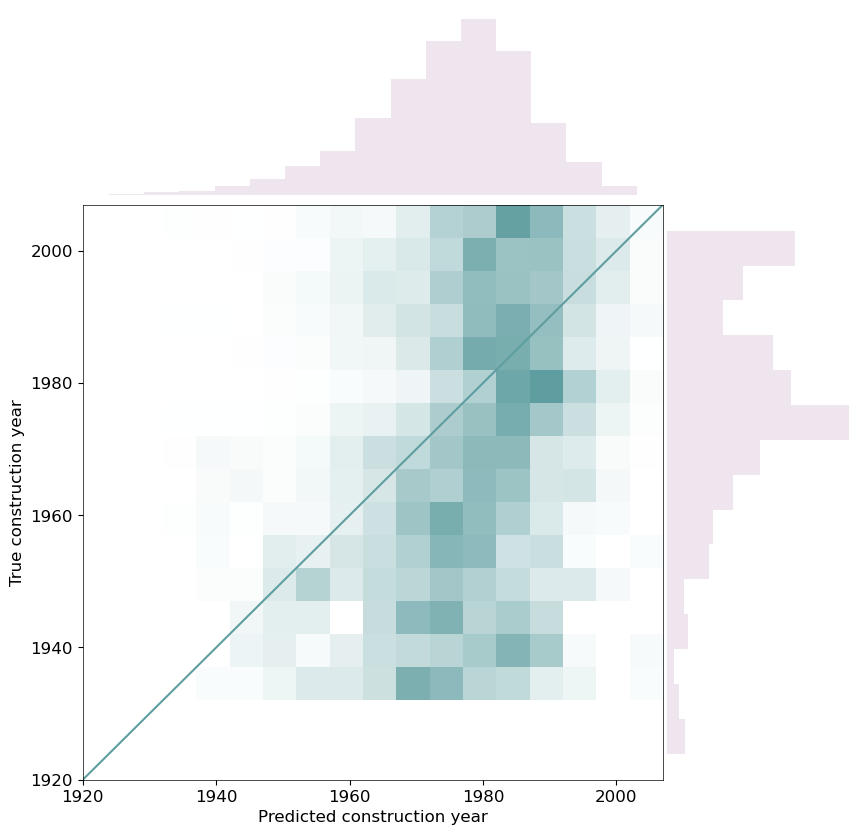

Train: Netherlands Test: Netherlands


2022-11-27 11:41:47,115 | INFO : Dataset length: 247520
2022-11-27 11:41:47,123 | INFO : Dataset allocated memory: 262 MB
2022-11-27 11:41:47,223 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-6f26bd90.abort.
2022-11-27 11:41:47,227 | INFO : Dataset standard deviation: 39.92809523509025
2022-11-27 11:41:47,228 | INFO : Dataset mean age: 1969.9830761150615
2022-11-27 11:41:47,228 | INFO : Training dataset length: 146203
2022-11-27 11:41:47,229 | INFO : Test dataset length: 30116
2022-11-27 11:41:47,804 | INFO : Test dataset standard deviation after preprocessing: 18.74174851579556
2022-11-27 11:41:47,804 | INFO : Test dataset mean age after preprocessing: 1982.7418146550283
2022-11-27 11:41:47,805 | INFO : Training dataset length after preprocessing: 144309
2022-11-27 11:41:47,805 | INFO : Test dataset length after preprocessing: 29901
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with s

MAE: 13.22 y
RMSE: 17.26 y
R2: 0.1516
R2: nan
MAPE: nan


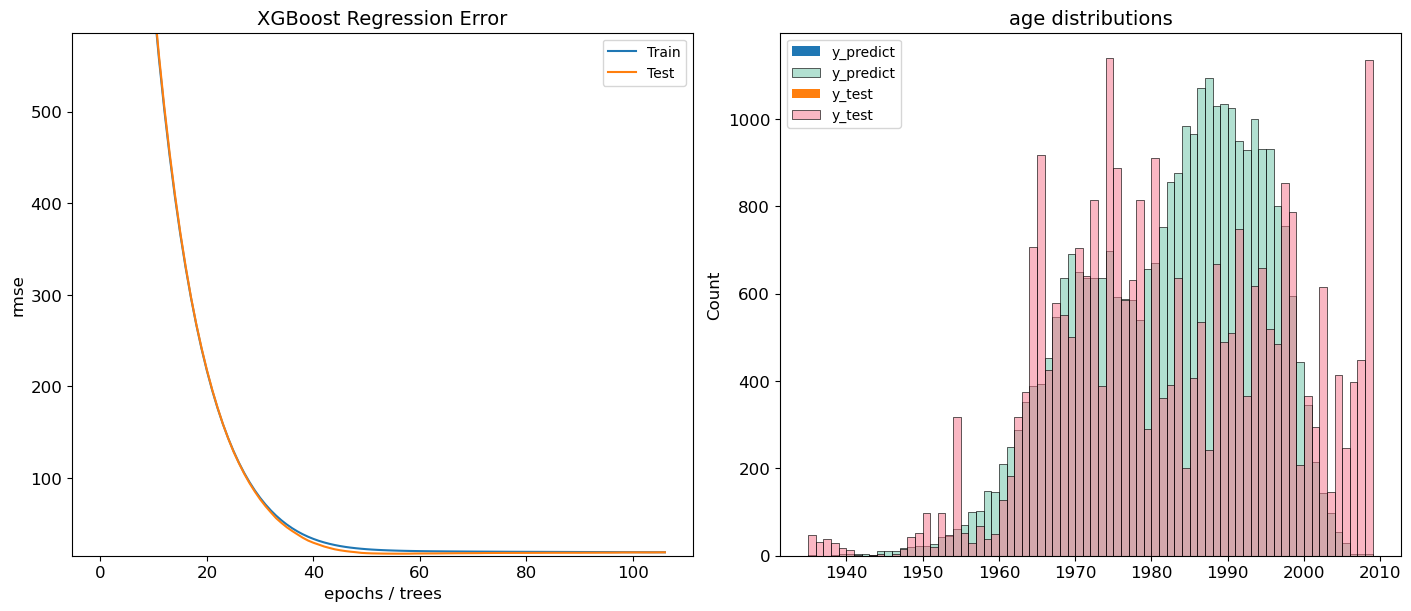

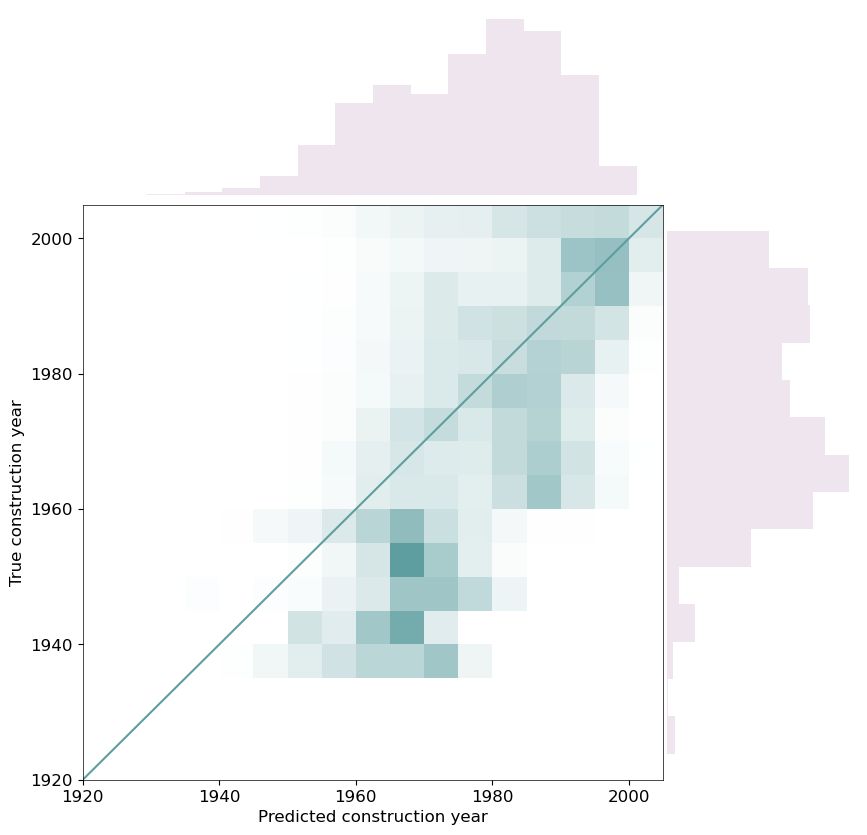

Train: Spain Test: Spain


2022-11-27 11:41:52,504 | INFO : Dataset length: 247520
2022-11-27 11:41:52,511 | INFO : Dataset allocated memory: 262 MB
2022-11-27 11:41:52,536 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-d927fba8.abort.
2022-11-27 11:41:52,539 | INFO : Dataset standard deviation: 39.92809523509025
2022-11-27 11:41:52,540 | INFO : Dataset mean age: 1969.9830761150615
2022-11-27 11:41:52,541 | INFO : Training dataset length: 17673
2022-11-27 11:41:52,541 | INFO : Test dataset length: 4262
2022-11-27 11:41:52,619 | INFO : Test dataset standard deviation after preprocessing: 23.754782738503593
2022-11-27 11:41:52,620 | INFO : Test dataset mean age after preprocessing: 1984.018508583691
2022-11-27 11:41:52,620 | INFO : Training dataset length after preprocessing: 17191
2022-11-27 11:41:52,621 | INFO : Test dataset length after preprocessing: 3728
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with sciki

MAE: 15.29 y
RMSE: 18.50 y
R2: 0.3933
R2: nan
MAPE: nan


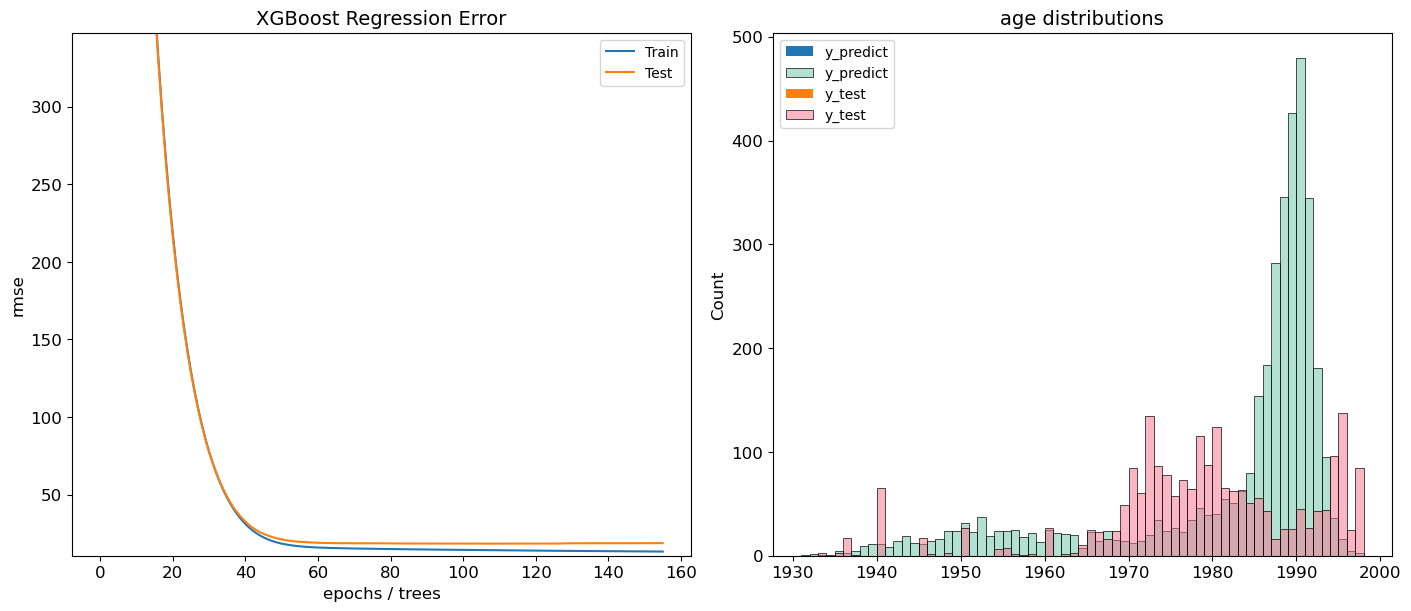

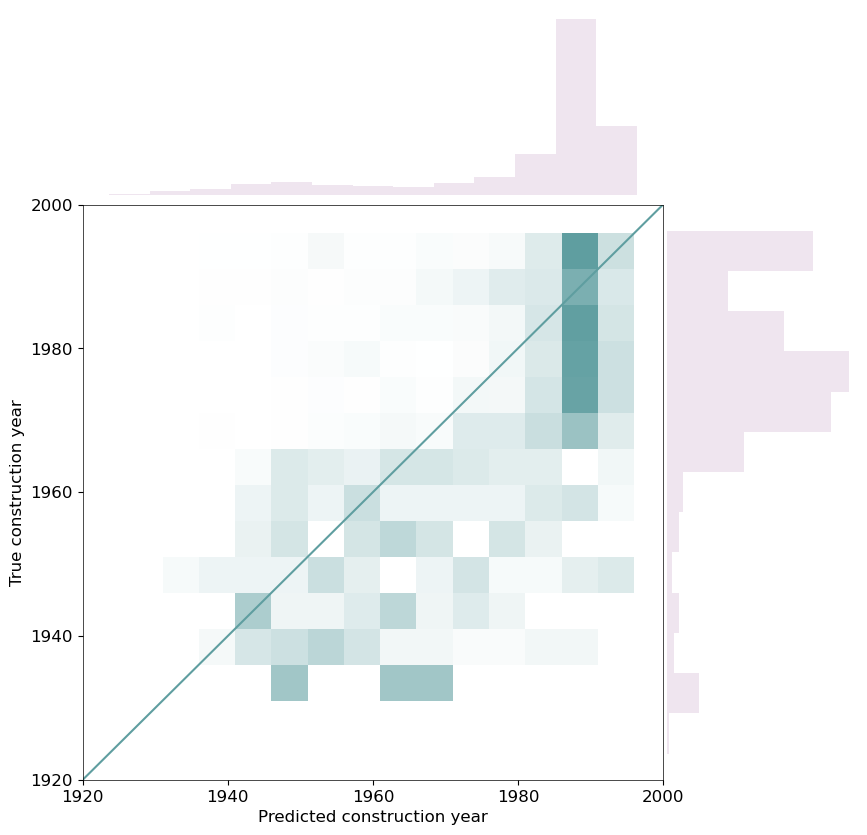

In [12]:
for country in config:
    print(f"Train: {country} Test: {country}")
    test_training_split = lambda df: get_cross_country_split(
        df, config=config, test_country=country, train_country=country
    )
    predictor = AgePredictor(
        model=XGBRegressor(**xgb_model_params),
        df=df.copy(),
        test_training_split=test_training_split,
        early_stopping=True,
        hyperparameters=xgb_hyperparams,
        preprocessing_stages=[pp.remove_outliers]
    )
    predictor.evaluate()

#### Cross-country Generalization

Train: France, Test: Netherlands


2022-11-27 11:41:54,996 | INFO : Dataset length: 247520
2022-11-27 11:41:55,004 | INFO : Dataset allocated memory: 262 MB
2022-11-27 11:41:55,090 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-61573945.abort.
2022-11-27 11:41:55,094 | INFO : Dataset standard deviation: 39.92809523509025
2022-11-27 11:41:55,095 | INFO : Dataset mean age: 1969.9830761150615
2022-11-27 11:41:55,095 | INFO : Training dataset length: 146203
2022-11-27 11:41:55,096 | INFO : Test dataset length: 10424
2022-11-27 11:41:55,627 | INFO : Test dataset standard deviation after preprocessing: 25.85459271143312
2022-11-27 11:41:55,628 | INFO : Test dataset mean age after preprocessing: 1979.240777809551
2022-11-27 11:41:55,628 | INFO : Training dataset length after preprocessing: 144309
2022-11-27 11:41:55,629 | INFO : Test dataset length after preprocessing: 6994
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with sci

MAE: 25.10 y
RMSE: 29.99 y
R2: -0.3457
R2: nan
MAPE: nan


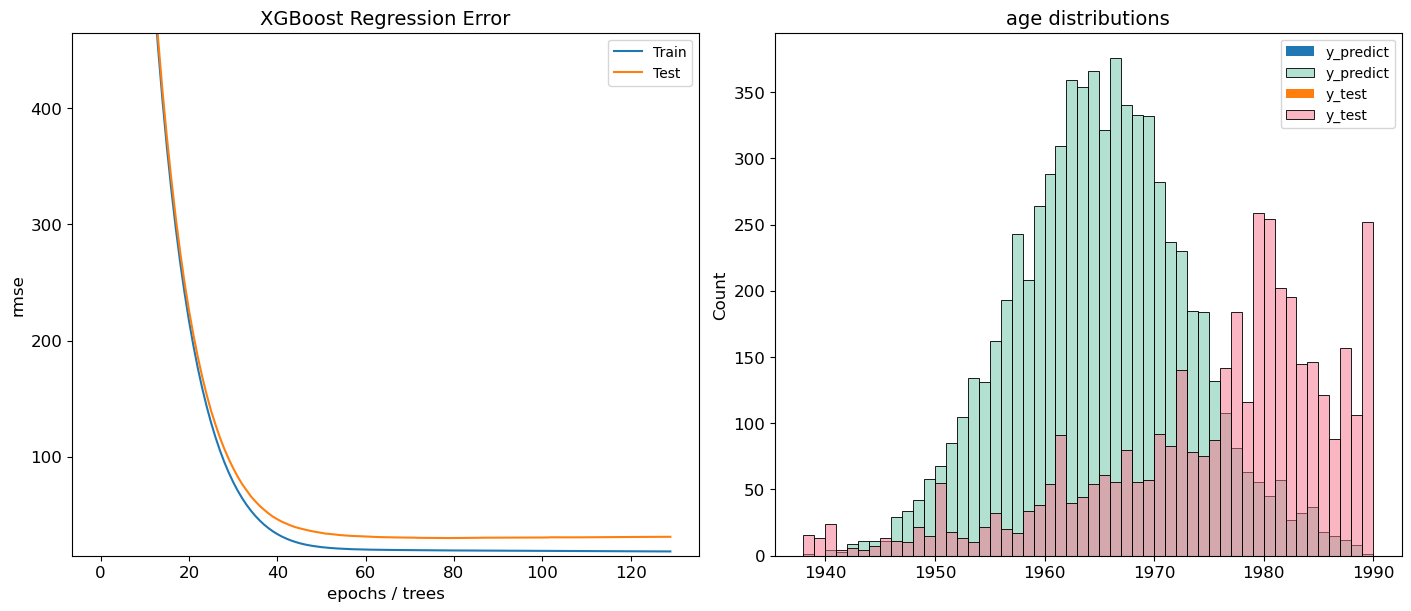

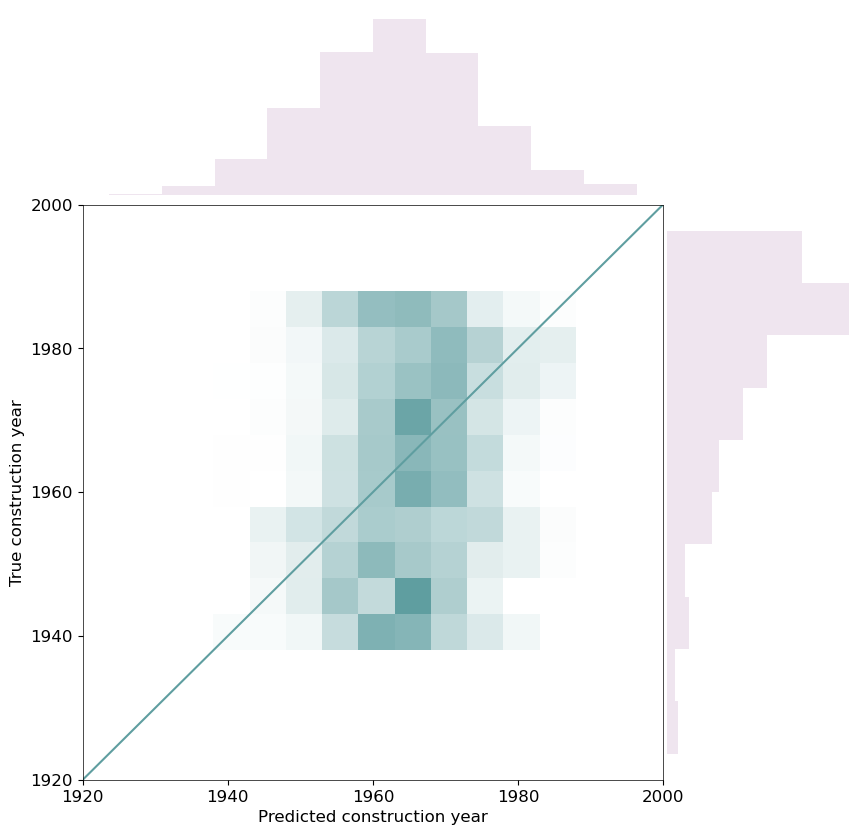

Train: France, Test: Spain


2022-11-27 11:42:00,144 | INFO : Dataset length: 247520
2022-11-27 11:42:00,152 | INFO : Dataset allocated memory: 262 MB
2022-11-27 11:42:00,188 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-4e3c0915.abort.
2022-11-27 11:42:00,193 | INFO : Dataset standard deviation: 39.92809523509025
2022-11-27 11:42:00,195 | INFO : Dataset mean age: 1969.9830761150615
2022-11-27 11:42:00,196 | INFO : Training dataset length: 17673
2022-11-27 11:42:00,196 | INFO : Test dataset length: 10424
2022-11-27 11:42:00,282 | INFO : Test dataset standard deviation after preprocessing: 25.85459271143312
2022-11-27 11:42:00,282 | INFO : Test dataset mean age after preprocessing: 1979.240777809551
2022-11-27 11:42:00,284 | INFO : Training dataset length after preprocessing: 17191
2022-11-27 11:42:00,285 | INFO : Test dataset length after preprocessing: 6994
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with sciki

MAE: 19.47 y
RMSE: 25.60 y
R2: 0.0194
R2: nan
MAPE: nan


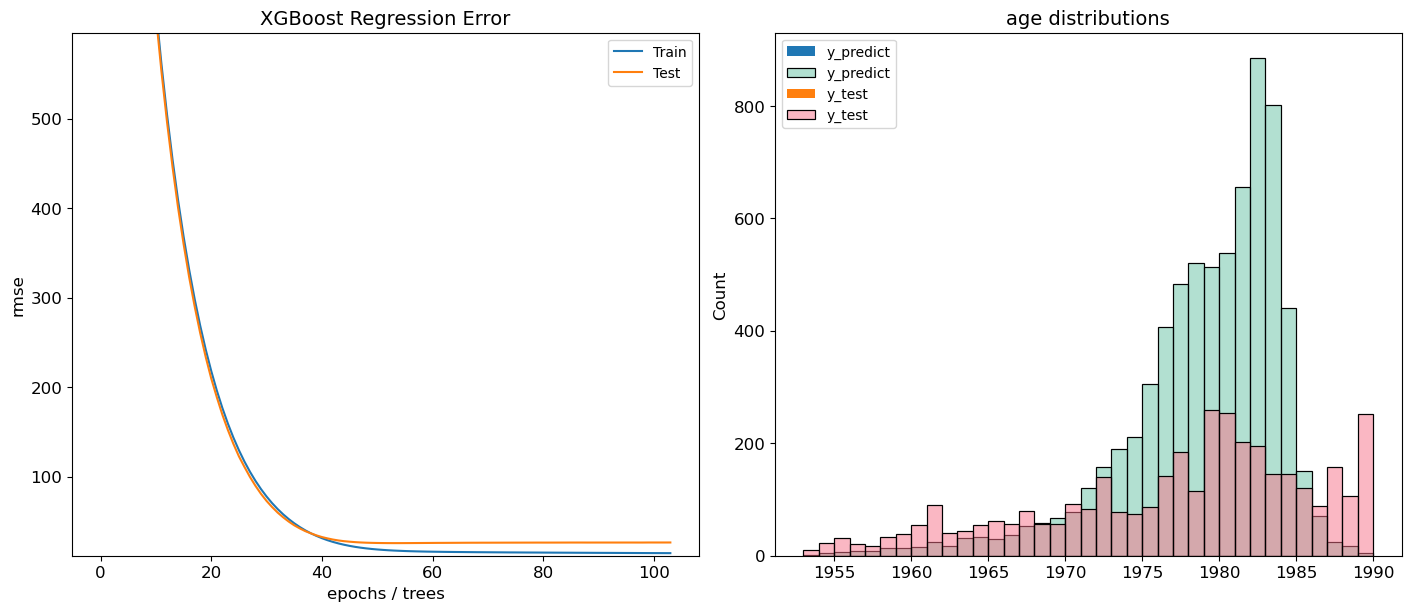

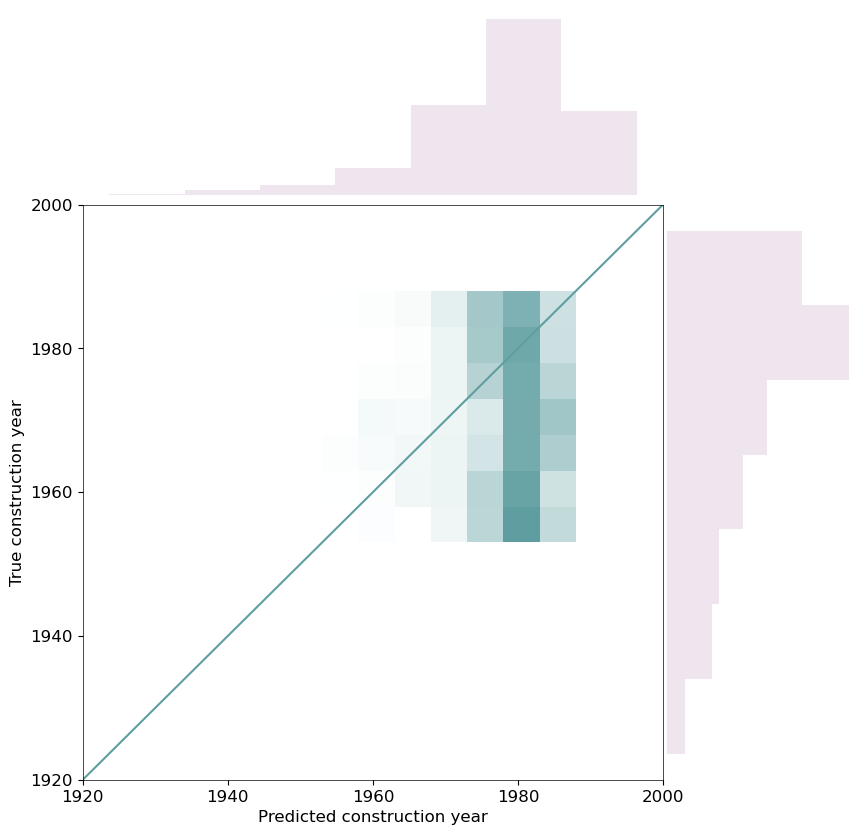

Train: Netherlands, Test: France


2022-11-27 11:42:02,134 | INFO : Dataset length: 247520
2022-11-27 11:42:02,141 | INFO : Dataset allocated memory: 262 MB
2022-11-27 11:42:02,185 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-a6a49e00.abort.
2022-11-27 11:42:02,190 | INFO : Dataset standard deviation: 39.92809523509025
2022-11-27 11:42:02,192 | INFO : Dataset mean age: 1969.9830761150615
2022-11-27 11:42:02,193 | INFO : Training dataset length: 38842
2022-11-27 11:42:02,193 | INFO : Test dataset length: 30116
2022-11-27 11:42:02,402 | INFO : Test dataset standard deviation after preprocessing: 18.74174851579556
2022-11-27 11:42:02,403 | INFO : Test dataset mean age after preprocessing: 1982.7418146550283
2022-11-27 11:42:02,403 | INFO : Training dataset length after preprocessing: 31742
2022-11-27 11:42:02,404 | INFO : Test dataset length after preprocessing: 29901
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with sci

MAE: 24.51 y
RMSE: 29.17 y
R2: -1.4228
R2: nan
MAPE: nan


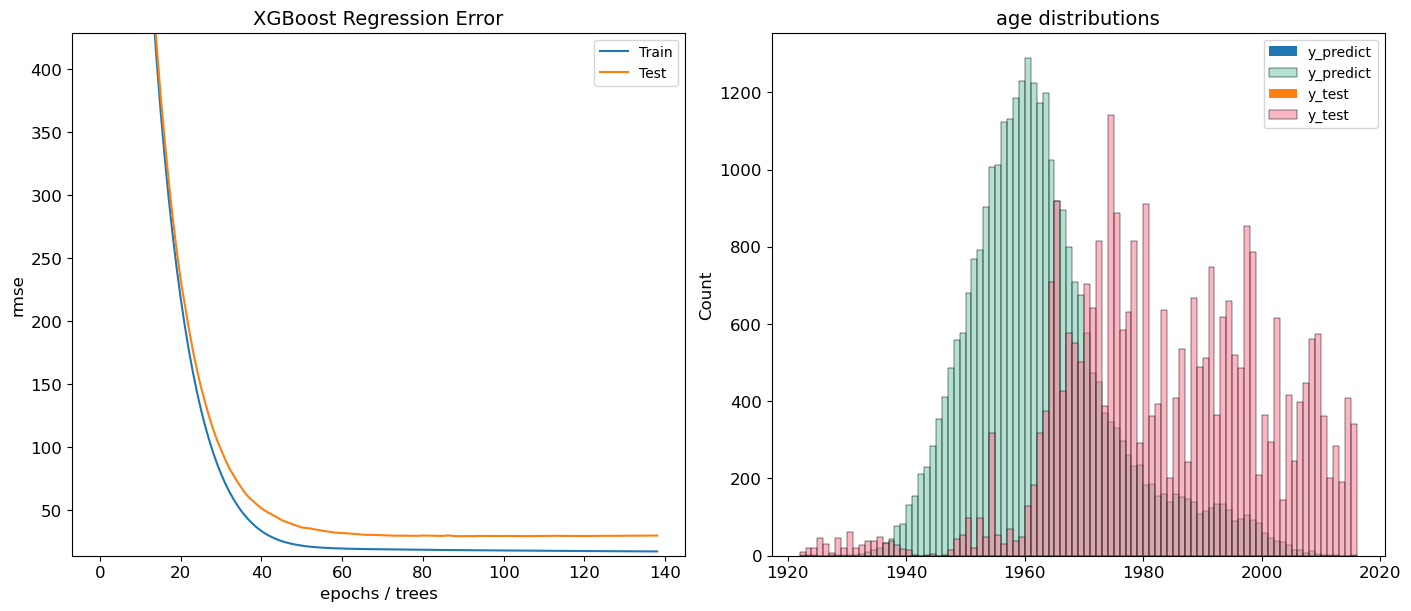

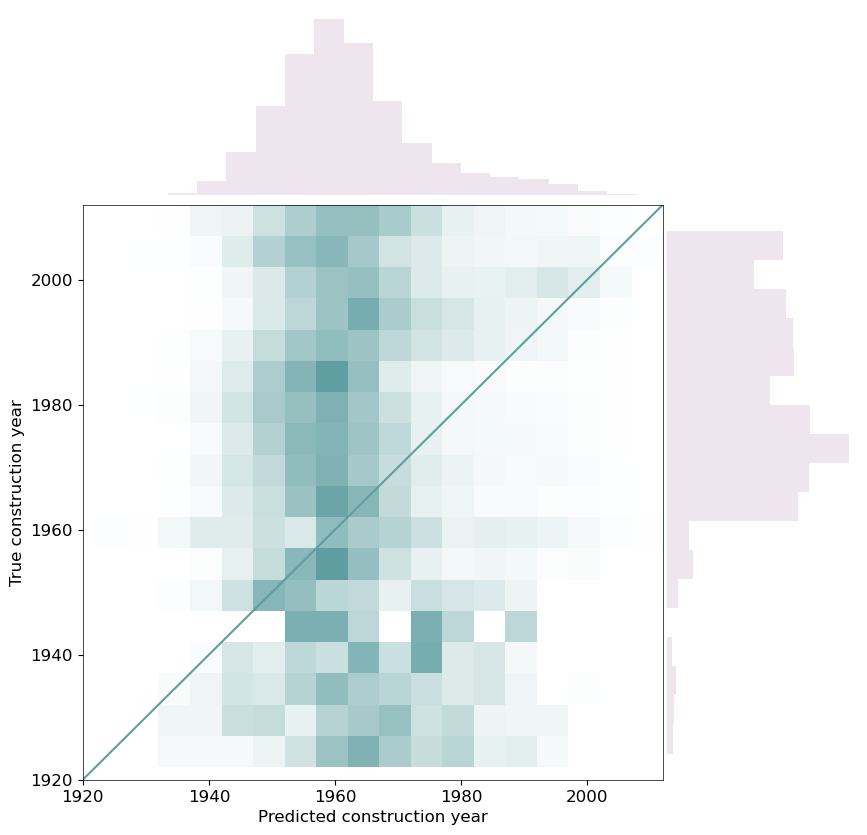

Train: Netherlands, Test: Spain


2022-11-27 11:42:05,561 | INFO : Dataset length: 247520
2022-11-27 11:42:05,568 | INFO : Dataset allocated memory: 262 MB
2022-11-27 11:42:05,608 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-11465308.abort.
2022-11-27 11:42:05,612 | INFO : Dataset standard deviation: 39.92809523509025
2022-11-27 11:42:05,613 | INFO : Dataset mean age: 1969.9830761150615
2022-11-27 11:42:05,613 | INFO : Training dataset length: 17673
2022-11-27 11:42:05,614 | INFO : Test dataset length: 30116
2022-11-27 11:42:05,769 | INFO : Test dataset standard deviation after preprocessing: 18.74174851579556
2022-11-27 11:42:05,770 | INFO : Test dataset mean age after preprocessing: 1982.7418146550283
2022-11-27 11:42:05,770 | INFO : Training dataset length after preprocessing: 17191
2022-11-27 11:42:05,771 | INFO : Test dataset length after preprocessing: 29901
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with sci

MAE: 14.55 y
RMSE: 19.22 y
R2: -0.0515
R2: nan
MAPE: nan


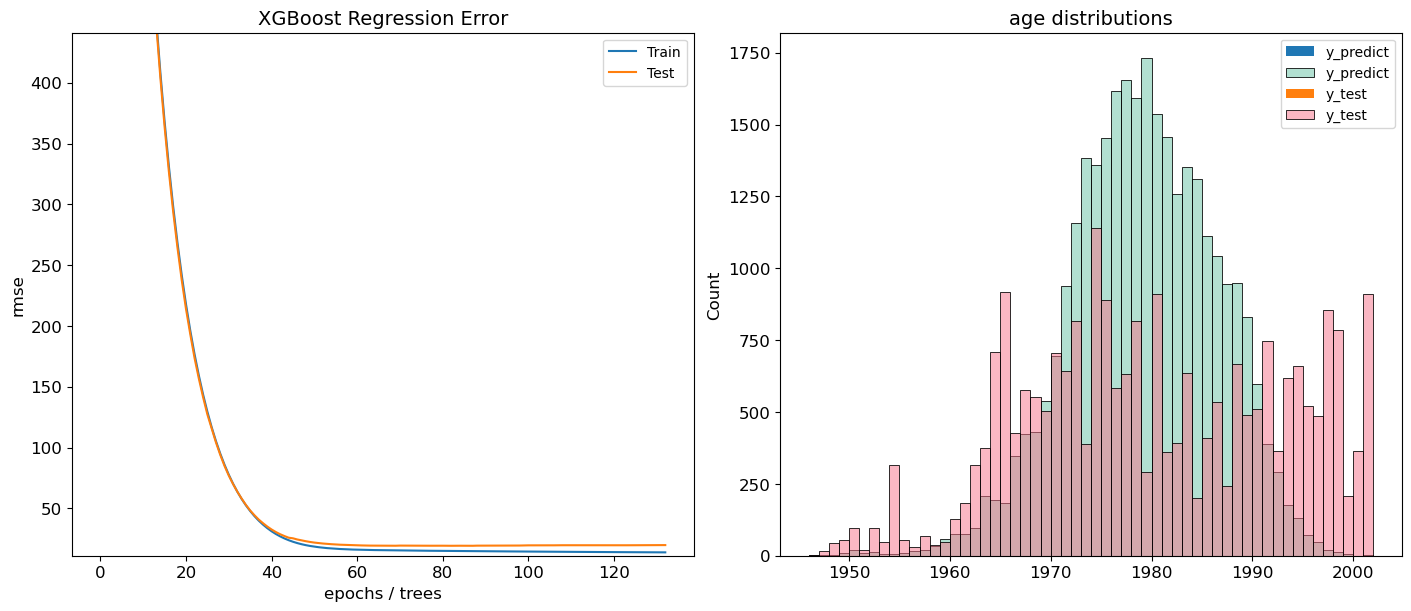

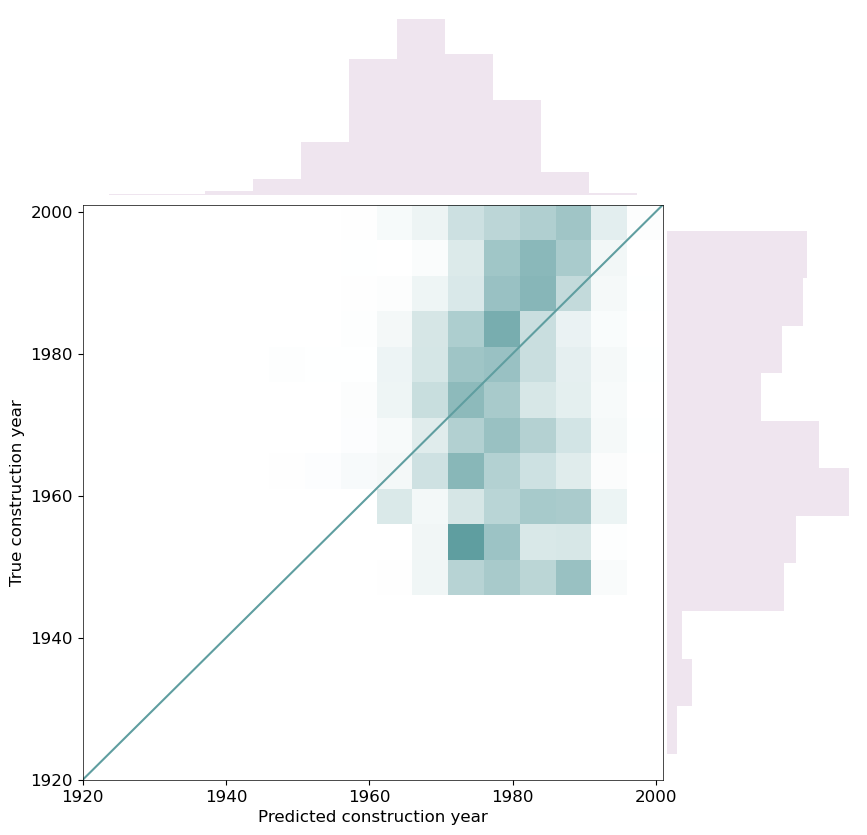

Train: Spain, Test: France


2022-11-27 11:42:08,273 | INFO : Dataset length: 247520
2022-11-27 11:42:08,281 | INFO : Dataset allocated memory: 262 MB
2022-11-27 11:42:08,315 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-f68d1059.abort.
2022-11-27 11:42:08,319 | INFO : Dataset standard deviation: 39.92809523509025
2022-11-27 11:42:08,321 | INFO : Dataset mean age: 1969.9830761150615
2022-11-27 11:42:08,321 | INFO : Training dataset length: 38842
2022-11-27 11:42:08,322 | INFO : Test dataset length: 4262
2022-11-27 11:42:08,450 | INFO : Test dataset standard deviation after preprocessing: 23.754782738503593
2022-11-27 11:42:08,451 | INFO : Test dataset mean age after preprocessing: 1984.018508583691
2022-11-27 11:42:08,451 | INFO : Training dataset length after preprocessing: 31742
2022-11-27 11:42:08,452 | INFO : Test dataset length after preprocessing: 3728
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with sciki

MAE: 18.40 y
RMSE: 22.54 y
R2: 0.0992
R2: nan
MAPE: nan


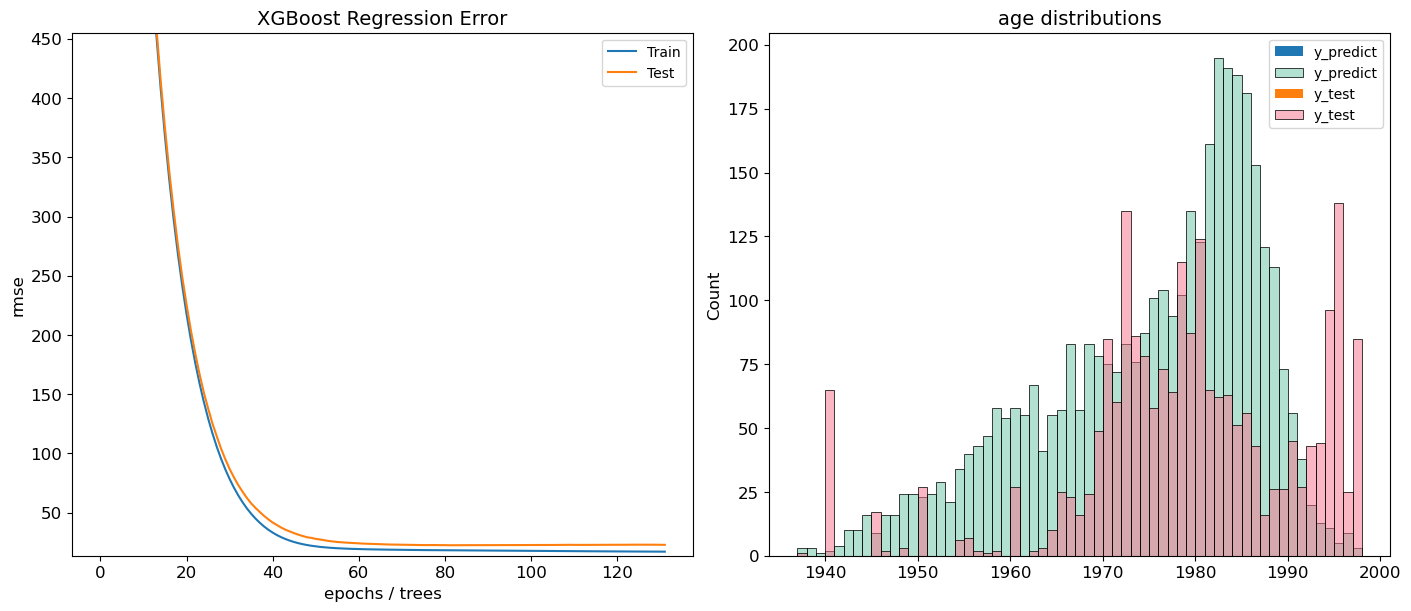

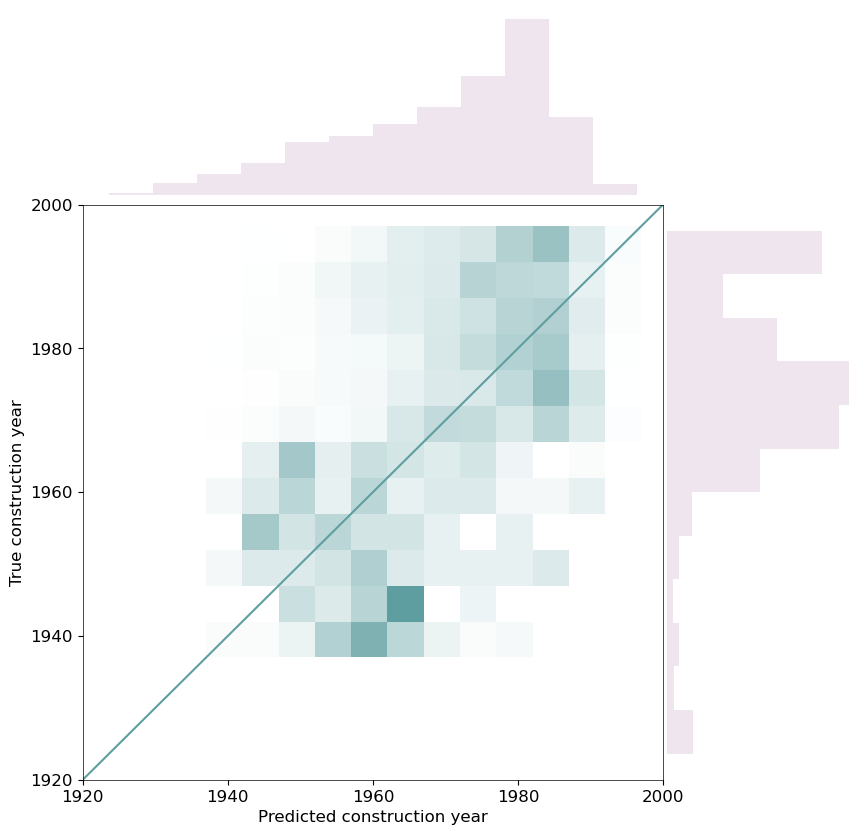

Train: Spain, Test: Netherlands


2022-11-27 11:42:11,012 | INFO : Dataset length: 247520
2022-11-27 11:42:11,021 | INFO : Dataset allocated memory: 262 MB
2022-11-27 11:42:11,100 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-8f27a103.abort.
2022-11-27 11:42:11,104 | INFO : Dataset standard deviation: 39.92809523509025
2022-11-27 11:42:11,105 | INFO : Dataset mean age: 1969.9830761150615
2022-11-27 11:42:11,106 | INFO : Training dataset length: 146203
2022-11-27 11:42:11,106 | INFO : Test dataset length: 4262
2022-11-27 11:42:11,618 | INFO : Test dataset standard deviation after preprocessing: 23.754782738503593
2022-11-27 11:42:11,619 | INFO : Test dataset mean age after preprocessing: 1984.018508583691
2022-11-27 11:42:11,619 | INFO : Training dataset length after preprocessing: 144309
2022-11-27 11:42:11,620 | INFO : Test dataset length after preprocessing: 3728
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with sci

MAE: 22.26 y
RMSE: 26.68 y
R2: -0.2622
R2: nan
MAPE: nan


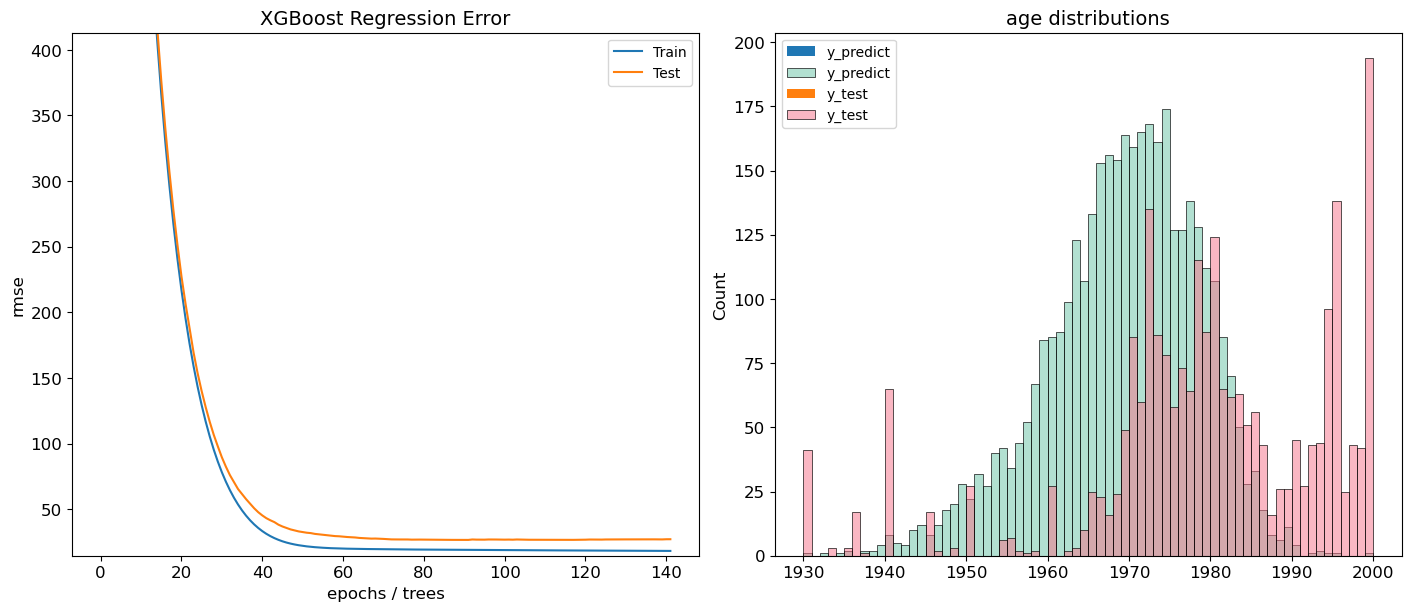

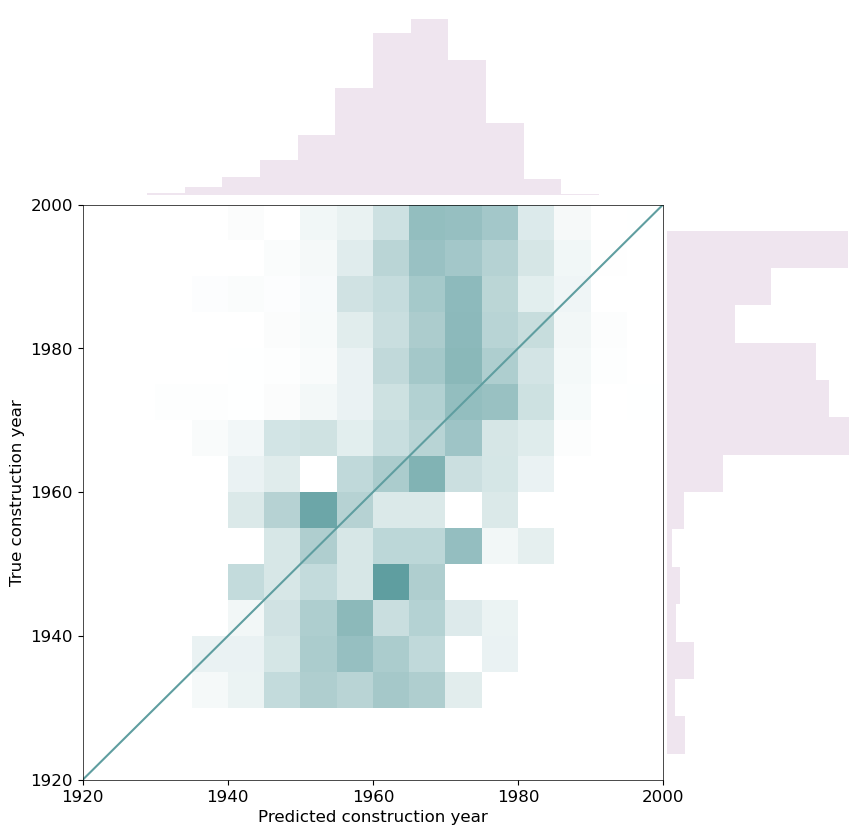

In [13]:
for train_country, test_country in itertools.permutations(list(config),2):
    print(f"Train: {train_country}, Test: {test_country}")
    test_training_split = lambda df: get_cross_country_split(
        df, config=config, test_country=train_country, train_country=test_country
    )
    predictor = AgePredictor(
        model=XGBRegressor(**xgb_model_params),
        df=df.copy(),
        test_training_split=test_training_split,
        early_stopping=True,
        hyperparameters=xgb_hyperparams,
        preprocessing_stages=[pp.remove_outliers]
    )
    predictor.evaluate()

#### Full Dataset

Train: ['France', 'Netherlands', 'Spain'] Test: France


2022-11-27 11:42:16,760 | INFO : Dataset length: 247520
2022-11-27 11:42:16,768 | INFO : Dataset allocated memory: 262 MB
2022-11-27 11:42:17,066 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-a06edd56.abort.
2022-11-27 11:42:17,071 | INFO : Dataset standard deviation: 39.92809523509025
2022-11-27 11:42:17,072 | INFO : Dataset mean age: 1969.9830761150615
2022-11-27 11:42:17,073 | INFO : Training dataset length: 202718
2022-11-27 11:42:17,074 | INFO : Test dataset length: 10424
2022-11-27 11:42:17,947 | INFO : Test dataset standard deviation after preprocessing: 25.85459271143312
2022-11-27 11:42:17,948 | INFO : Test dataset mean age after preprocessing: 1979.240777809551
2022-11-27 11:42:17,949 | INFO : Training dataset length after preprocessing: 193242
2022-11-27 11:42:17,950 | INFO : Test dataset length after preprocessing: 6994
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with sci

MAE: 18.52 y
RMSE: 24.44 y
R2: 0.1064
R2: nan
MAPE: nan


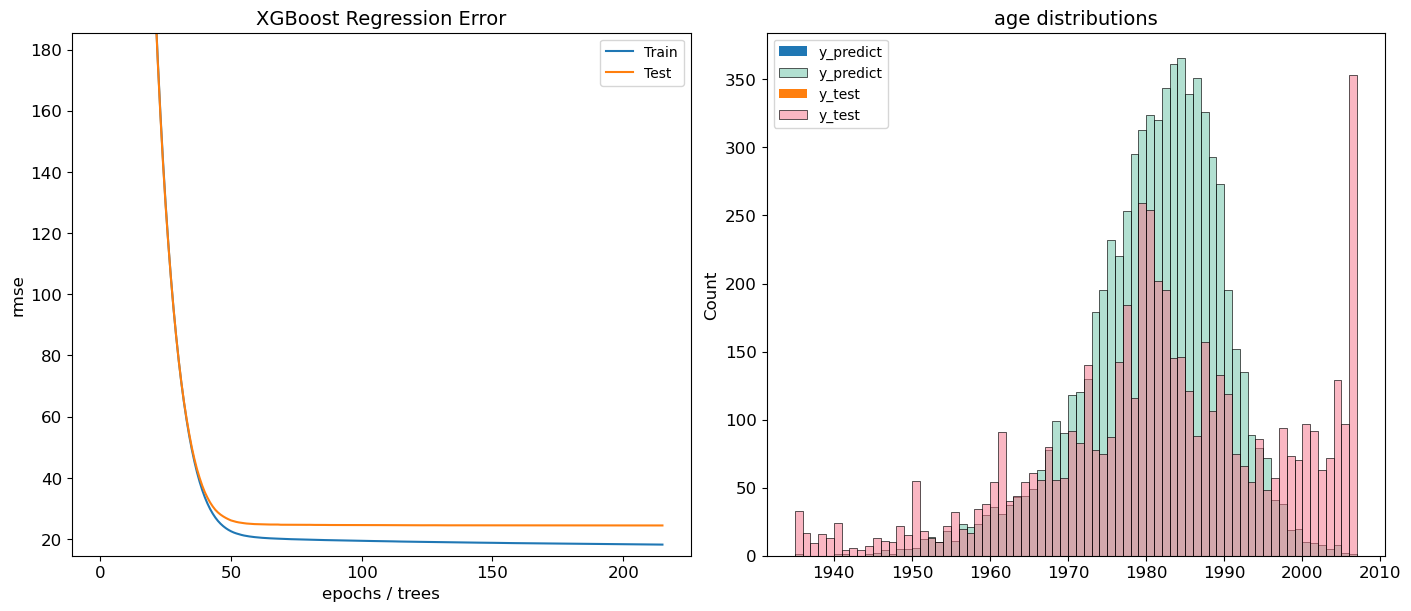

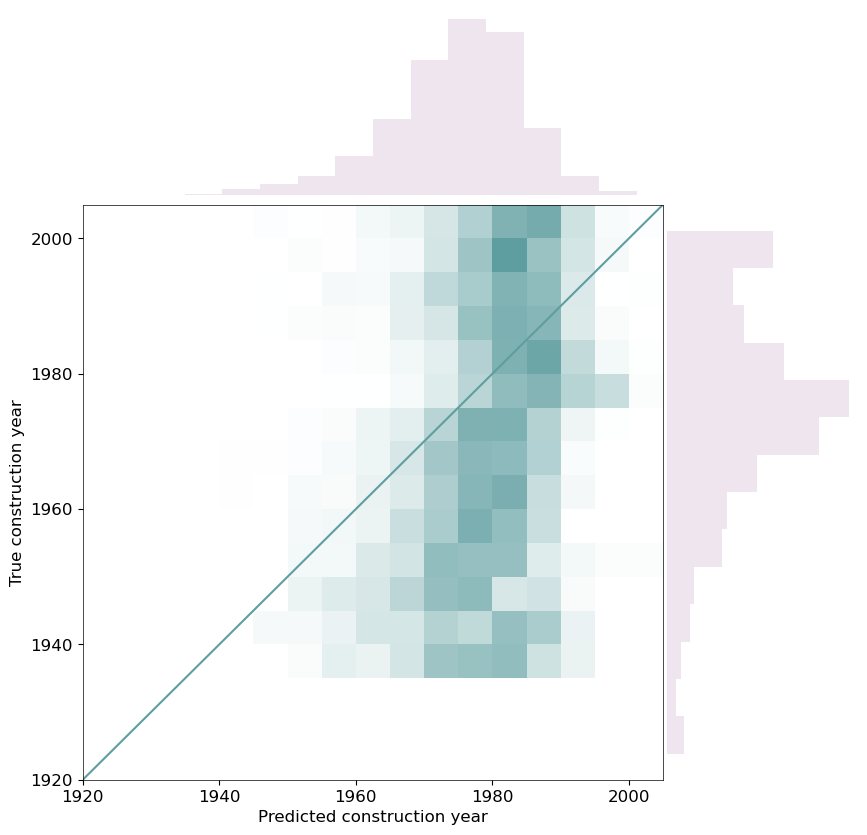

Train: ['France', 'Netherlands', 'Spain'] Test: Netherlands


2022-11-27 11:42:27,221 | INFO : Dataset length: 247520
2022-11-27 11:42:27,229 | INFO : Dataset allocated memory: 262 MB
2022-11-27 11:42:27,539 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-2e2daa1e.abort.
2022-11-27 11:42:27,542 | INFO : Dataset standard deviation: 39.92809523509025
2022-11-27 11:42:27,544 | INFO : Dataset mean age: 1969.9830761150615
2022-11-27 11:42:27,545 | INFO : Training dataset length: 202718
2022-11-27 11:42:27,545 | INFO : Test dataset length: 30116
2022-11-27 11:42:28,469 | INFO : Test dataset standard deviation after preprocessing: 18.74174851579556
2022-11-27 11:42:28,470 | INFO : Test dataset mean age after preprocessing: 1982.7418146550283
2022-11-27 11:42:28,470 | INFO : Training dataset length after preprocessing: 193242
2022-11-27 11:42:28,471 | INFO : Test dataset length after preprocessing: 29901
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with s

MAE: 13.41 y
RMSE: 17.28 y
R2: 0.1502
R2: nan
MAPE: nan


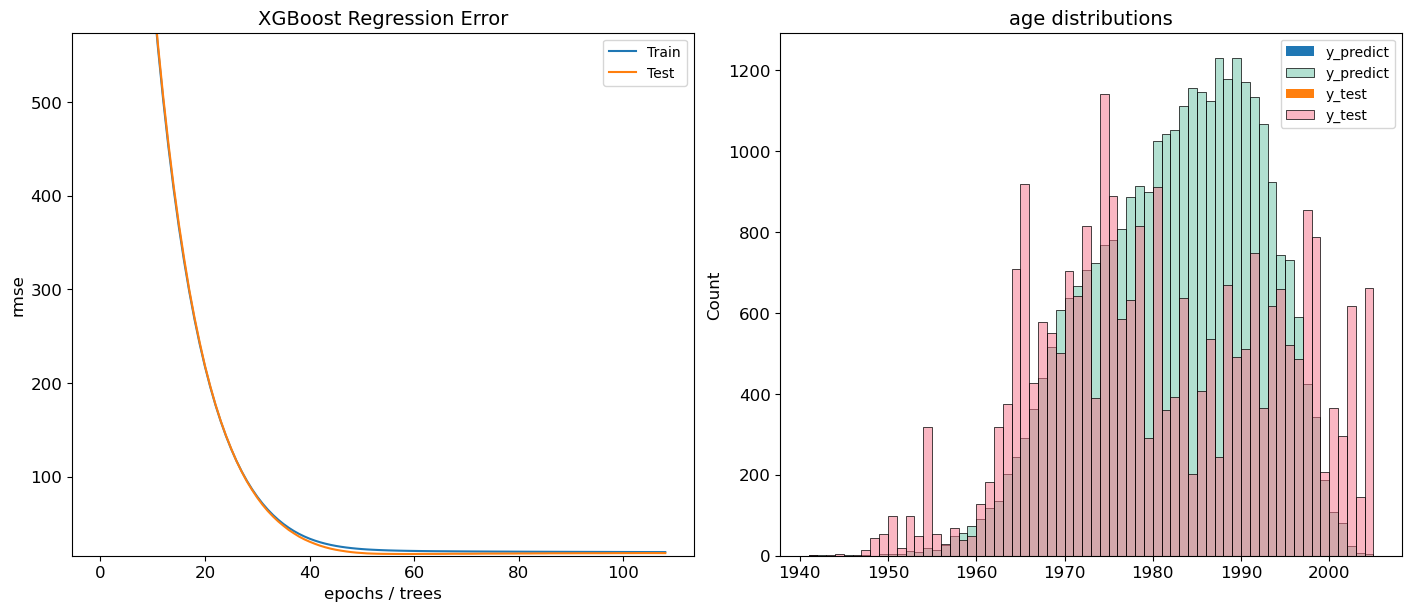

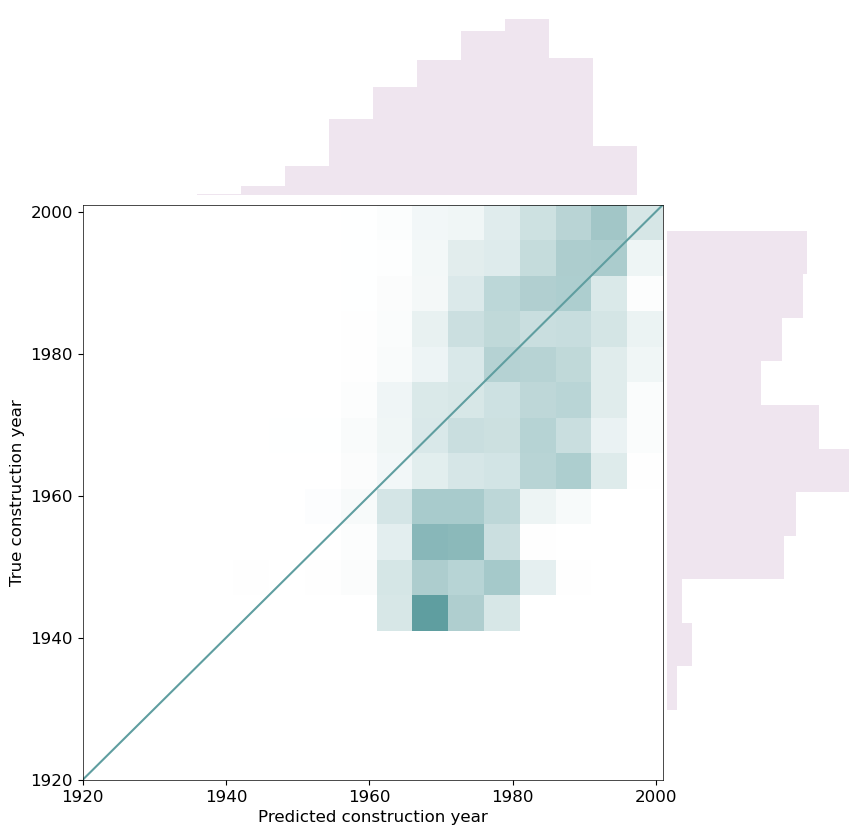

Train: ['France', 'Netherlands', 'Spain'] Test: Spain


2022-11-27 11:42:34,223 | INFO : Dataset length: 247520
2022-11-27 11:42:34,232 | INFO : Dataset allocated memory: 262 MB
2022-11-27 11:42:34,531 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-48216f00.abort.
2022-11-27 11:42:34,534 | INFO : Dataset standard deviation: 39.92809523509025
2022-11-27 11:42:34,536 | INFO : Dataset mean age: 1969.9830761150615
2022-11-27 11:42:34,536 | INFO : Training dataset length: 202718
2022-11-27 11:42:34,537 | INFO : Test dataset length: 4262
2022-11-27 11:42:35,367 | INFO : Test dataset standard deviation after preprocessing: 23.754782738503593
2022-11-27 11:42:35,368 | INFO : Test dataset mean age after preprocessing: 1984.018508583691
2022-11-27 11:42:35,369 | INFO : Training dataset length after preprocessing: 193242
2022-11-27 11:42:35,370 | INFO : Test dataset length after preprocessing: 3728
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with sci

MAE: 16.73 y
RMSE: 20.86 y
R2: 0.2285
R2: nan
MAPE: nan


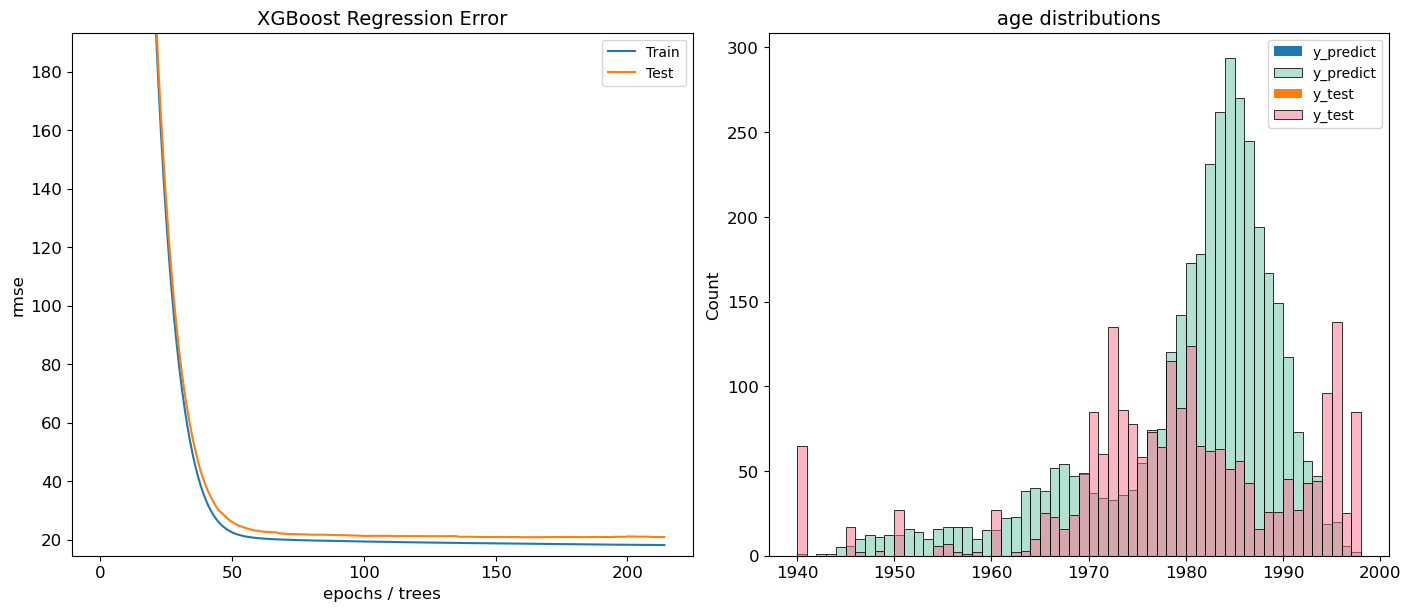

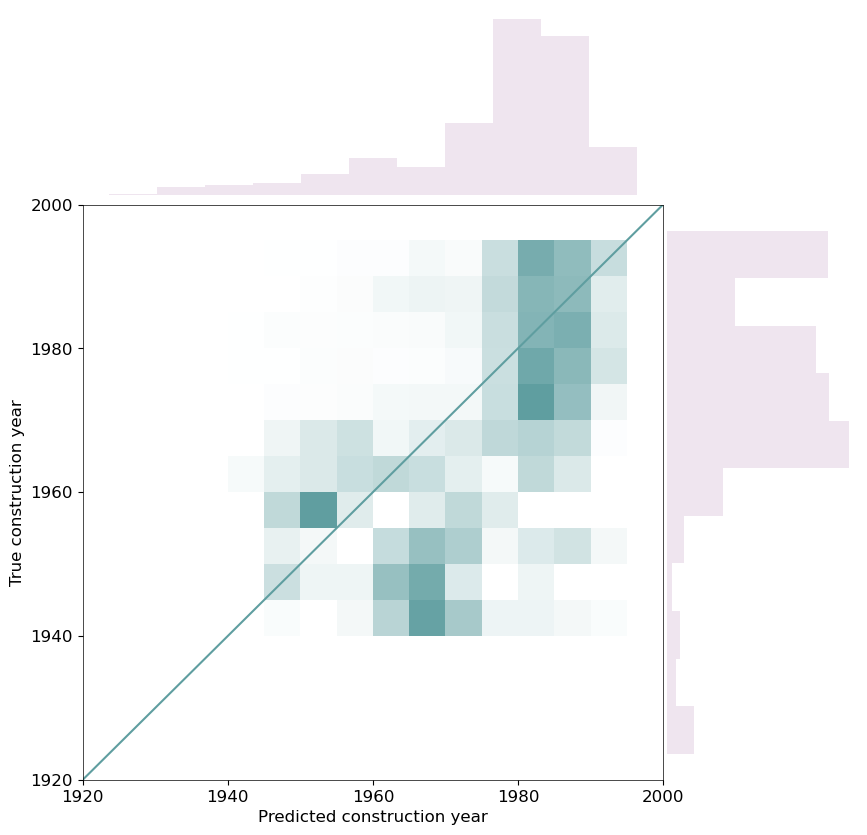

In [14]:
for country in config:
    print(f"Train: {list(config)} Test: {country}")
    test_training_split = lambda df: get_cross_country_split(
        df, config=config, test_country=country
    )
    predictor = AgePredictor(
        model=XGBRegressor(**xgb_model_params),
        df=df.copy(),
        test_training_split=test_training_split,
        early_stopping=True,
        hyperparameters=xgb_hyperparams,
        preprocessing_stages=[pp.remove_outliers]
    )
    predictor.evaluate()

### Building Age Classification

#### Per-city Split

2022-11-27 16:36:06,465 | INFO : Generated bins: [1900, 1965, 1975, 1992, 2006, 2015, 2022]
2022-11-27 16:36:06,465 | INFO : Generated bins with the following labels: ['1900-1964', '1965-1974', '1975-1991', '1992-2005', '2006-2014', '2015-2021']


Train: France Test: France


2022-11-27 16:36:06,806 | INFO : Dataset length: 247520
2022-11-27 16:36:06,814 | INFO : Dataset allocated memory: 262 MB
2022-11-27 16:36:06,865 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-6152577f.abort.
2022-11-27 16:36:06,866 | INFO : Training dataset length: 38842
2022-11-27 16:36:06,867 | INFO : Test dataset length: 10424
2022-11-27 16:36:06,869 | INFO : Test cities: ['Oullins' 'Royat' 'Saint-Ciers-sur-Gironde']
2022-11-27 16:36:06,951 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2022-11-27 16:36:07,010 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2022-11-27 16:36:07,134 | INFO : Training dataset length after preprocessing: 31742
2022-11-27 16:36:07,135 | INFO : Test dataset length after preprocessing: 6994
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

Classification report:
               precision    recall  f1-score  support
1900-1964      0.453852  0.420198  0.436377     1416
1965-1974      0.218421  0.213368  0.215865      778
1975-1991      0.474884  0.485963  0.480360     2529
1992-2005      0.263936  0.211293  0.234699     1098
2006-2014      0.266929  0.321327  0.291613     1055
2015-2021      0.026882  0.042373  0.032895      118
accuracy       0.366886  0.366886  0.366886        0
macro avg      0.284151  0.282420  0.281968     6994
weighted avg   0.370053  0.366886  0.367446     6994
Cohen’s kappa: 0.1763
Matthews correlation coefficient (MCC): 0.1765


FixedFormatter should only be used together with FixedLocator


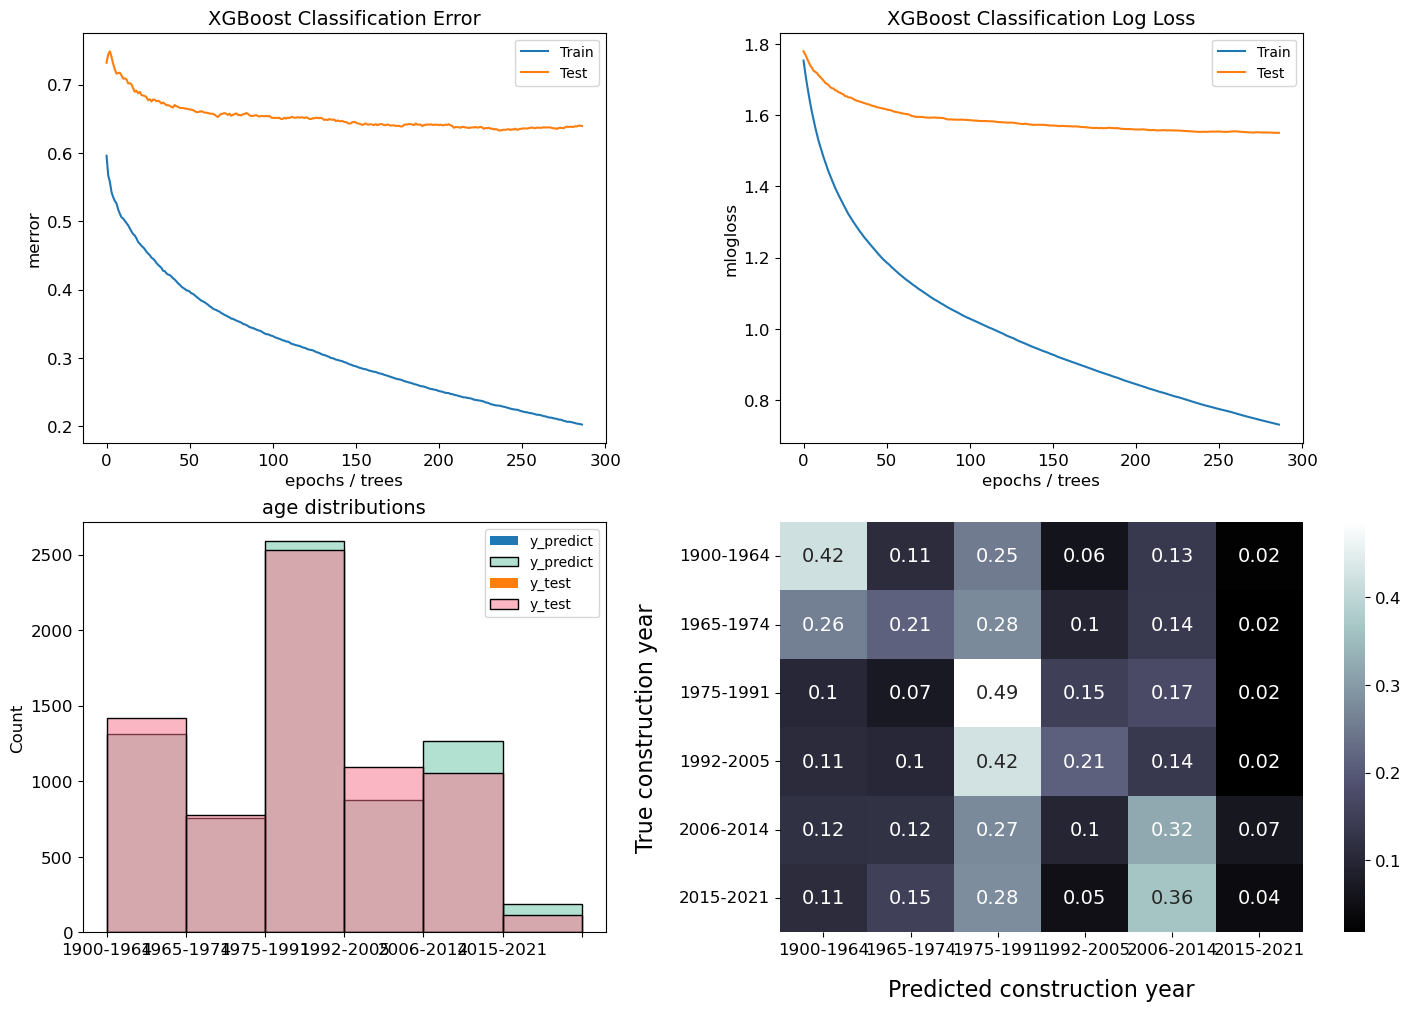

2022-11-27 16:36:23,017 | INFO : Generated bins: [1900, 1965, 1975, 1992, 2006, 2015, 2022]
2022-11-27 16:36:23,018 | INFO : Generated bins with the following labels: ['1900-1964', '1965-1974', '1975-1991', '1992-2005', '2006-2014', '2015-2021']


Train: Netherlands Test: Netherlands


2022-11-27 16:36:23,318 | INFO : Dataset length: 247520
2022-11-27 16:36:23,327 | INFO : Dataset allocated memory: 262 MB
2022-11-27 16:36:23,433 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-c807f77c.abort.
2022-11-27 16:36:23,434 | INFO : Training dataset length: 146203
2022-11-27 16:36:23,434 | INFO : Test dataset length: 30116
2022-11-27 16:36:23,436 | INFO : Test cities: ['Dronten' 'Jacobswoude' 'Renkum']
2022-11-27 16:36:23,715 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2022-11-27 16:36:23,910 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2022-11-27 16:36:24,359 | INFO : Training dataset length after preprocessing: 144309
2022-11-27 16:36:24,359 | INFO : Test dataset length after preprocessing: 29901
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use 

Classification report:
               precision    recall  f1-score  support
1900-1964      0.451682  0.239118  0.312696     3538
1965-1974      0.480314  0.523481  0.500969     6665
1975-1991      0.404716  0.292937  0.339872     9316
1992-2005      0.353759  0.305366  0.327786     6579
2006-2014      0.214596  0.359848  0.268858     3432
2015-2021      0.037882  0.264151  0.066261      371
accuracy       0.348015  0.348015  0.348015        0
macro avg      0.323825  0.330817  0.302740    29901
weighted avg   0.389539  0.348015  0.358360    29901
Cohen’s kappa: 0.1883
Matthews correlation coefficient (MCC): 0.1911


FixedFormatter should only be used together with FixedLocator


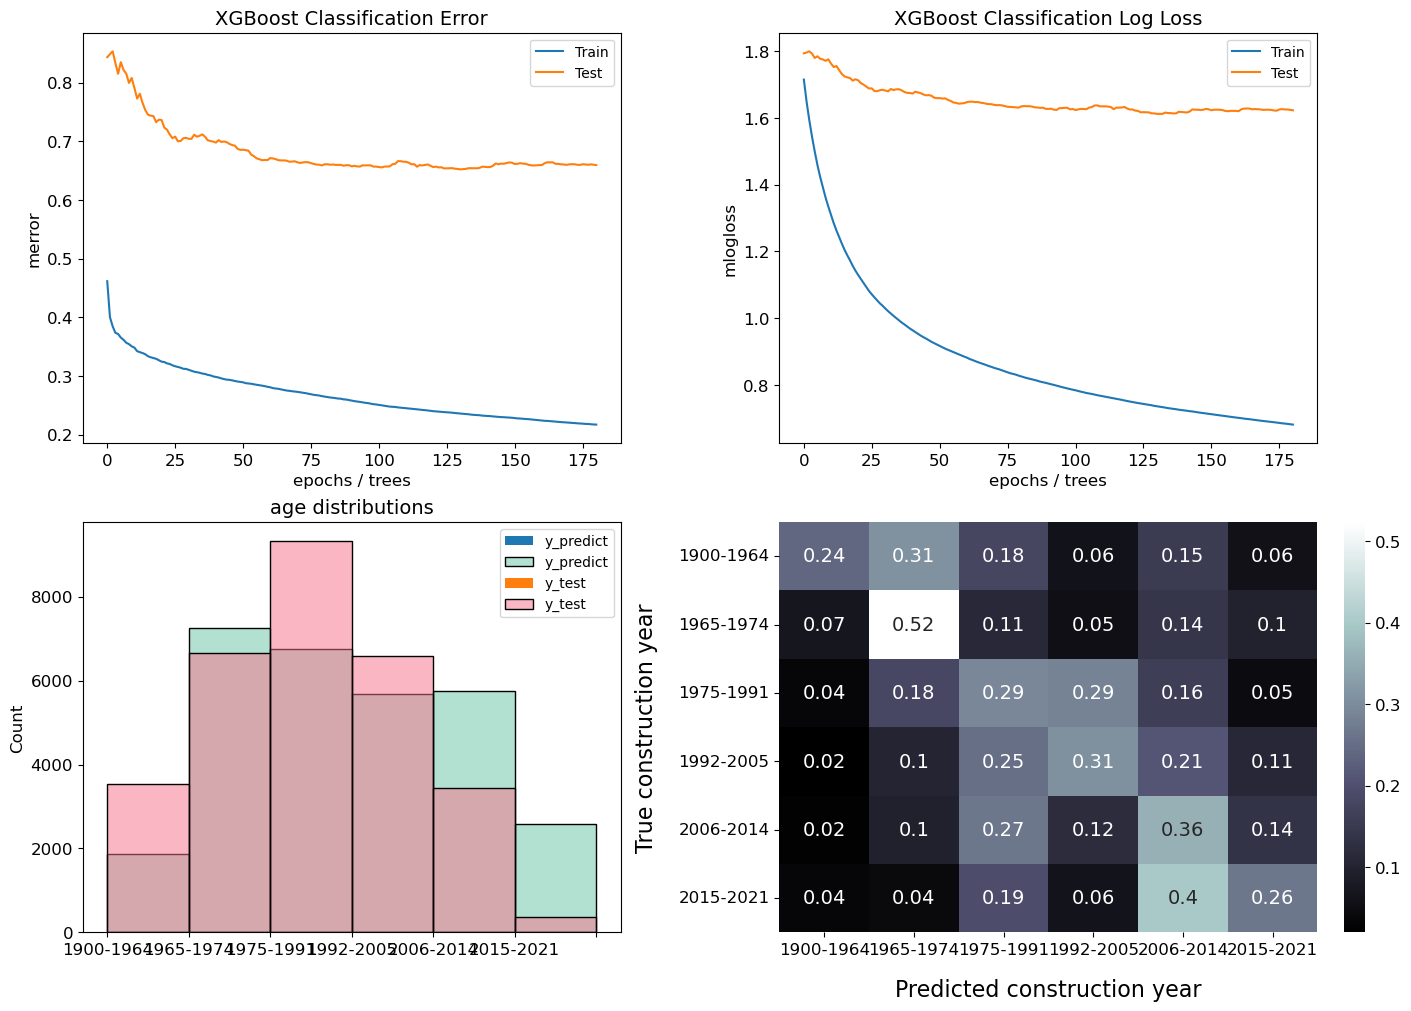

2022-11-27 16:36:54,495 | INFO : Generated bins: [1900, 1965, 1975, 1992, 2006, 2015, 2022]
2022-11-27 16:36:54,496 | INFO : Generated bins with the following labels: ['1900-1964', '1965-1974', '1975-1991', '1992-2005', '2006-2014', '2015-2021']


Train: Spain Test: Spain


2022-11-27 16:36:54,845 | INFO : Dataset length: 247520
2022-11-27 16:36:54,854 | INFO : Dataset allocated memory: 262 MB
2022-11-27 16:36:54,889 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-dd020a6a.abort.
2022-11-27 16:36:54,890 | INFO : Training dataset length: 17673
2022-11-27 16:36:54,890 | INFO : Test dataset length: 4262
2022-11-27 16:36:54,891 | INFO : Test cities: ['Piera' 'Quintanilla de la Mata' 'San Martín del Castañar']
2022-11-27 16:36:54,943 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2022-11-27 16:36:54,974 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2022-11-27 16:36:55,050 | INFO : Training dataset length after preprocessing: 17191
2022-11-27 16:36:55,050 | INFO : Test dataset length after preprocessing: 3728
`early_stopping_rounds` in `fit` method is deprecated for better compatibility w

Classification report:
               precision    recall  f1-score  support
1900-1964      0.609477  0.871495  0.717308      428
1965-1974      0.387097  0.020654  0.039216      581
1975-1991      0.364865  0.458541  0.406375     1001
1992-2005      0.346939  0.556364  0.427374     1100
2006-2014      0.433333  0.023214  0.044068      560
2015-2021      0.030303  0.017241  0.021978       58
accuracy       0.394313  0.394313  0.394313        0
macro avg      0.362002  0.324585  0.276053     3728
weighted avg   0.396203  0.394313  0.330643     3728
Cohen’s kappa: 0.1906
Matthews correlation coefficient (MCC): 0.2025


FixedFormatter should only be used together with FixedLocator


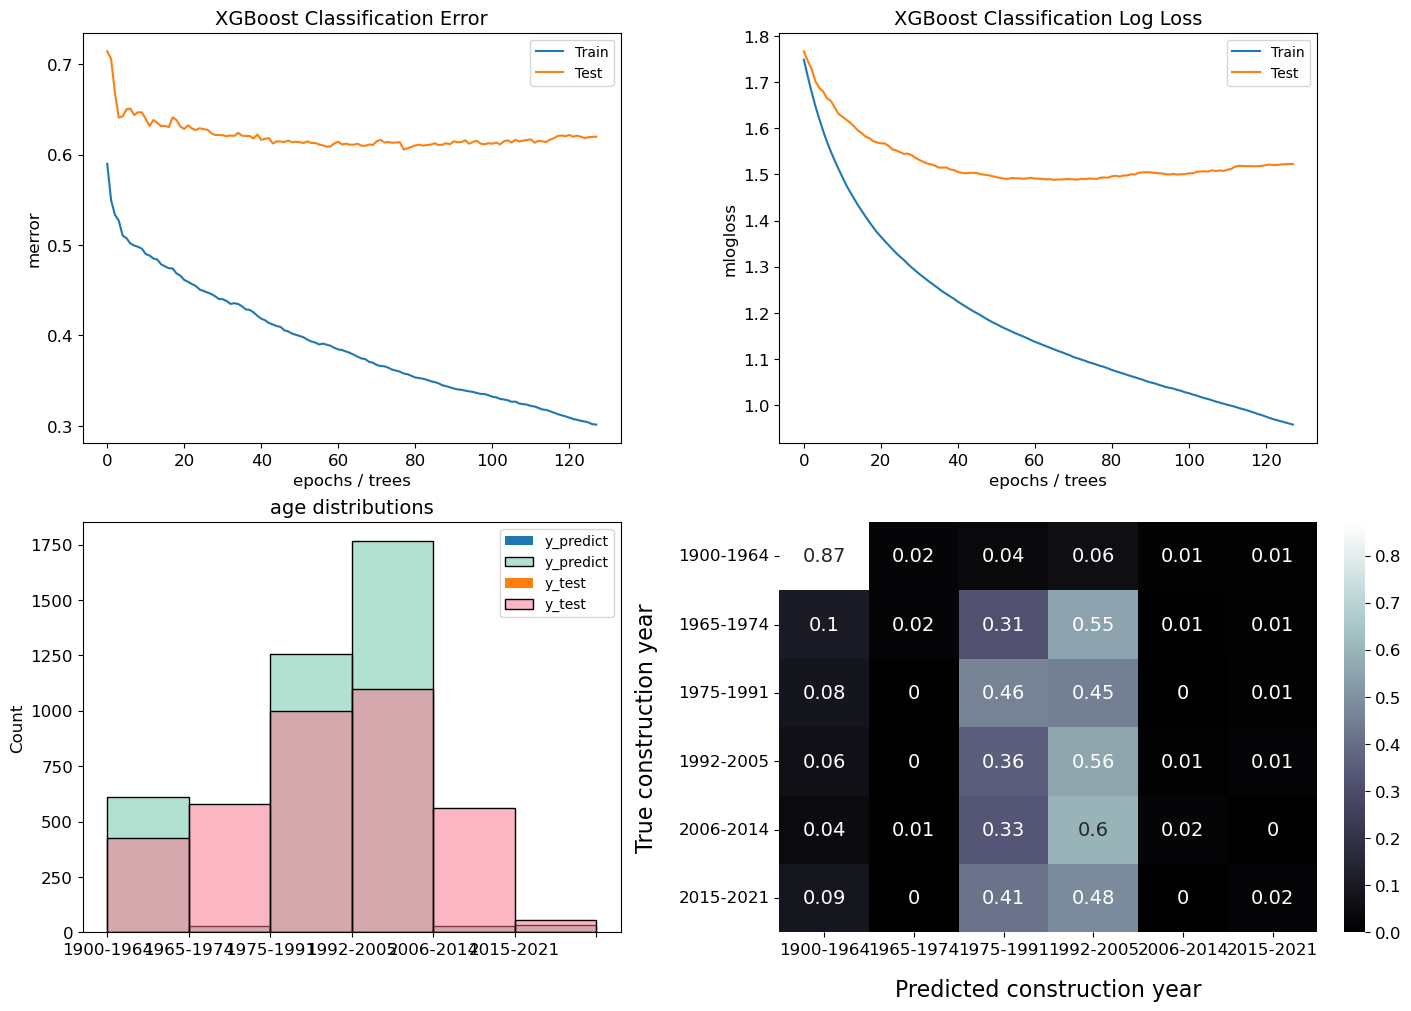

In [41]:
tabula_nl_bins = [1900, 1965, 1975, 1992, 2006, 2015, 2022]
equally_sized_bins = (1900, 2020, 10)

for country in config:
    print(f"Train: {country} Test: {country}")
    test_training_split = lambda df: get_cross_country_split(
        df, config=config, test_country=country, train_country=country
    )
    classifier = AgeClassifier(
        model=XGBClassifier(**xgb_model_params),
        df=df.copy(),
        test_training_split=test_training_split,
        preprocessing_stages=[pp.remove_outliers],
        hyperparameters=xgb_hyperparams,
        mitigate_class_imbalance=True,
        bins=tabula_nl_bins,
    )
    classifier.evaluate()

#### Cross-country Generalization

2022-11-27 16:37:13,589 | INFO : Generated bins: [1900, 1965, 1975, 1992, 2006, 2015, 2022]
2022-11-27 16:37:13,590 | INFO : Generated bins with the following labels: ['1900-1964', '1965-1974', '1975-1991', '1992-2005', '2006-2014', '2015-2021']


Train: France, Test: Netherlands


2022-11-27 16:37:13,887 | INFO : Dataset length: 247520
2022-11-27 16:37:13,896 | INFO : Dataset allocated memory: 262 MB
2022-11-27 16:37:13,927 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-4d0c6403.abort.
2022-11-27 16:37:13,928 | INFO : Training dataset length: 17673
2022-11-27 16:37:13,928 | INFO : Test dataset length: 4262
2022-11-27 16:37:13,931 | INFO : Test cities: ['Piera' 'Quintanilla de la Mata' 'San Martín del Castañar']
2022-11-27 16:37:13,976 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2022-11-27 16:37:14,004 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2022-11-27 16:37:14,064 | INFO : Training dataset length after preprocessing: 17191
2022-11-27 16:37:14,064 | INFO : Test dataset length after preprocessing: 3728
`early_stopping_rounds` in `fit` method is deprecated for better compatibility w

Classification report:
               precision    recall  f1-score  support
1900-1964      0.609477  0.871495  0.717308      428
1965-1974      0.387097  0.020654  0.039216      581
1975-1991      0.364865  0.458541  0.406375     1001
1992-2005      0.346939  0.556364  0.427374     1100
2006-2014      0.433333  0.023214  0.044068      560
2015-2021      0.030303  0.017241  0.021978       58
accuracy       0.394313  0.394313  0.394313        0
macro avg      0.362002  0.324585  0.276053     3728
weighted avg   0.396203  0.394313  0.330643     3728
Cohen’s kappa: 0.1906
Matthews correlation coefficient (MCC): 0.2025


FixedFormatter should only be used together with FixedLocator


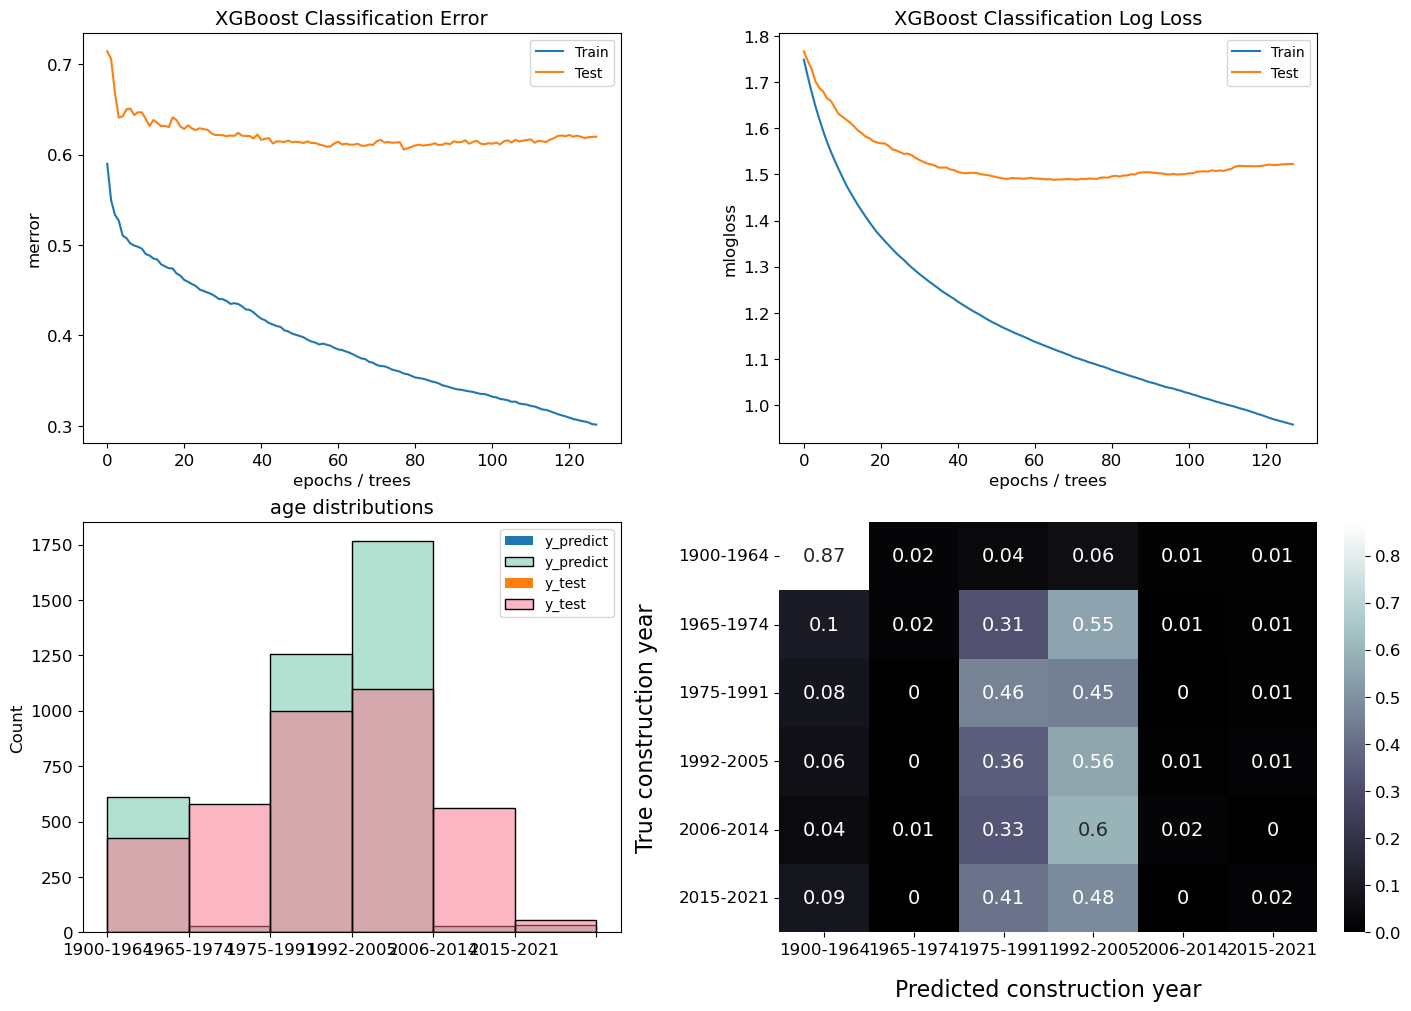

2022-11-27 16:37:20,268 | INFO : Generated bins: [1900, 1965, 1975, 1992, 2006, 2015, 2022]
2022-11-27 16:37:20,269 | INFO : Generated bins with the following labels: ['1900-1964', '1965-1974', '1975-1991', '1992-2005', '2006-2014', '2015-2021']


Train: France, Test: Spain


2022-11-27 16:37:20,614 | INFO : Dataset length: 247520
2022-11-27 16:37:20,625 | INFO : Dataset allocated memory: 262 MB
2022-11-27 16:37:20,659 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-75a4202a.abort.
2022-11-27 16:37:20,660 | INFO : Training dataset length: 17673
2022-11-27 16:37:20,661 | INFO : Test dataset length: 4262
2022-11-27 16:37:20,662 | INFO : Test cities: ['Piera' 'Quintanilla de la Mata' 'San Martín del Castañar']
2022-11-27 16:37:20,711 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2022-11-27 16:37:20,744 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2022-11-27 16:37:20,817 | INFO : Training dataset length after preprocessing: 17191
2022-11-27 16:37:20,818 | INFO : Test dataset length after preprocessing: 3728
`early_stopping_rounds` in `fit` method is deprecated for better compatibility w

Classification report:
               precision    recall  f1-score  support
1900-1964      0.609477  0.871495  0.717308      428
1965-1974      0.387097  0.020654  0.039216      581
1975-1991      0.364865  0.458541  0.406375     1001
1992-2005      0.346939  0.556364  0.427374     1100
2006-2014      0.433333  0.023214  0.044068      560
2015-2021      0.030303  0.017241  0.021978       58
accuracy       0.394313  0.394313  0.394313        0
macro avg      0.362002  0.324585  0.276053     3728
weighted avg   0.396203  0.394313  0.330643     3728
Cohen’s kappa: 0.1906
Matthews correlation coefficient (MCC): 0.2025


FixedFormatter should only be used together with FixedLocator


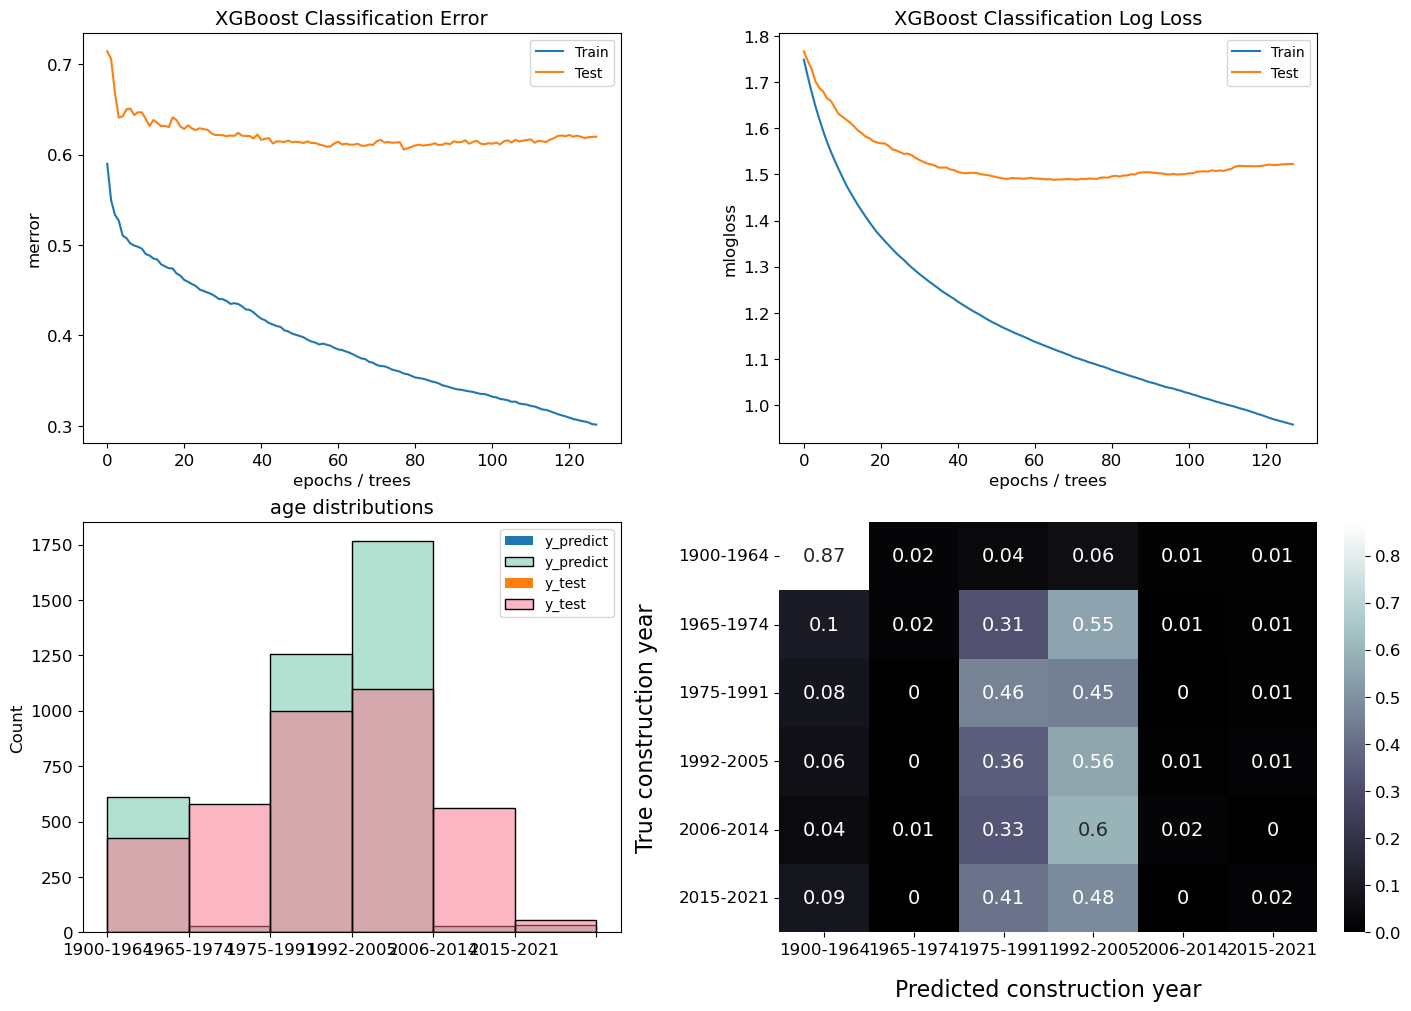

2022-11-27 16:37:27,243 | INFO : Generated bins: [1900, 1965, 1975, 1992, 2006, 2015, 2022]
2022-11-27 16:37:27,244 | INFO : Generated bins with the following labels: ['1900-1964', '1965-1974', '1975-1991', '1992-2005', '2006-2014', '2015-2021']


Train: Netherlands, Test: France


2022-11-27 16:37:27,595 | INFO : Dataset length: 247520
2022-11-27 16:37:27,603 | INFO : Dataset allocated memory: 262 MB
2022-11-27 16:37:27,638 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-ce748756.abort.
2022-11-27 16:37:27,638 | INFO : Training dataset length: 17673
2022-11-27 16:37:27,639 | INFO : Test dataset length: 4262
2022-11-27 16:37:27,641 | INFO : Test cities: ['Piera' 'Quintanilla de la Mata' 'San Martín del Castañar']
2022-11-27 16:37:27,688 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2022-11-27 16:37:27,720 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2022-11-27 16:37:27,785 | INFO : Training dataset length after preprocessing: 17191
2022-11-27 16:37:27,786 | INFO : Test dataset length after preprocessing: 3728
`early_stopping_rounds` in `fit` method is deprecated for better compatibility w

Classification report:
               precision    recall  f1-score  support
1900-1964      0.609477  0.871495  0.717308      428
1965-1974      0.387097  0.020654  0.039216      581
1975-1991      0.364865  0.458541  0.406375     1001
1992-2005      0.346939  0.556364  0.427374     1100
2006-2014      0.433333  0.023214  0.044068      560
2015-2021      0.030303  0.017241  0.021978       58
accuracy       0.394313  0.394313  0.394313        0
macro avg      0.362002  0.324585  0.276053     3728
weighted avg   0.396203  0.394313  0.330643     3728
Cohen’s kappa: 0.1906
Matthews correlation coefficient (MCC): 0.2025


FixedFormatter should only be used together with FixedLocator


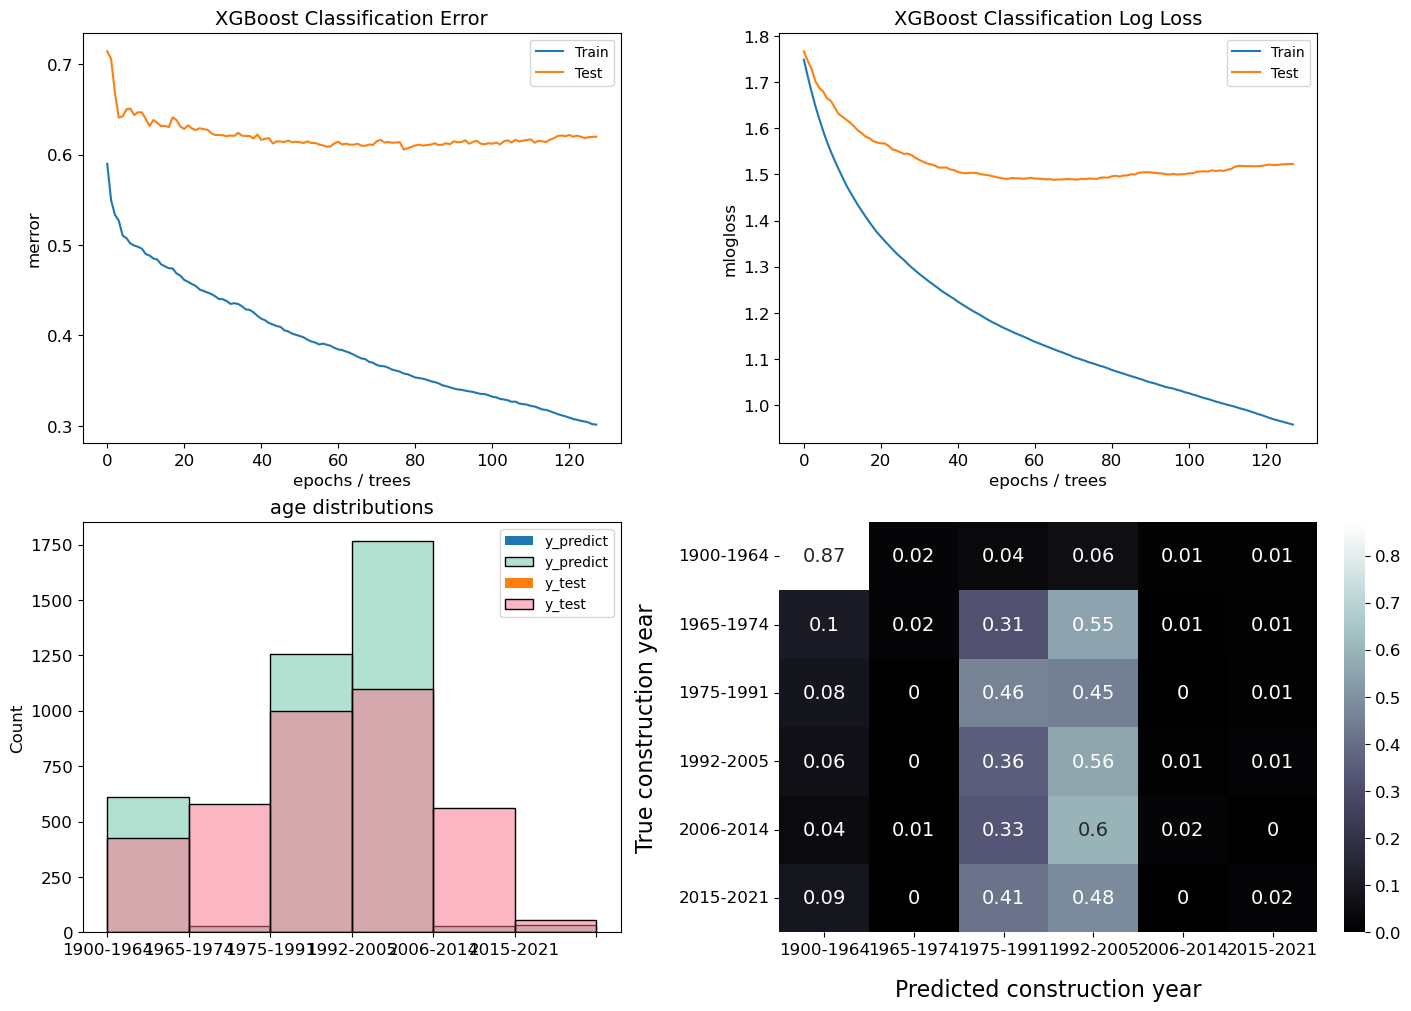

2022-11-27 16:37:33,910 | INFO : Generated bins: [1900, 1965, 1975, 1992, 2006, 2015, 2022]
2022-11-27 16:37:33,910 | INFO : Generated bins with the following labels: ['1900-1964', '1965-1974', '1975-1991', '1992-2005', '2006-2014', '2015-2021']


Train: Netherlands, Test: Spain


2022-11-27 16:37:34,226 | INFO : Dataset length: 247520
2022-11-27 16:37:34,238 | INFO : Dataset allocated memory: 262 MB
2022-11-27 16:37:34,273 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-9cbc6d2a.abort.
2022-11-27 16:37:34,273 | INFO : Training dataset length: 17673
2022-11-27 16:37:34,274 | INFO : Test dataset length: 4262
2022-11-27 16:37:34,276 | INFO : Test cities: ['Piera' 'Quintanilla de la Mata' 'San Martín del Castañar']
2022-11-27 16:37:34,725 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2022-11-27 16:37:34,757 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2022-11-27 16:37:34,823 | INFO : Training dataset length after preprocessing: 17191
2022-11-27 16:37:34,824 | INFO : Test dataset length after preprocessing: 3728
`early_stopping_rounds` in `fit` method is deprecated for better compatibility w

Classification report:
               precision    recall  f1-score  support
1900-1964      0.609477  0.871495  0.717308      428
1965-1974      0.387097  0.020654  0.039216      581
1975-1991      0.364865  0.458541  0.406375     1001
1992-2005      0.346939  0.556364  0.427374     1100
2006-2014      0.433333  0.023214  0.044068      560
2015-2021      0.030303  0.017241  0.021978       58
accuracy       0.394313  0.394313  0.394313        0
macro avg      0.362002  0.324585  0.276053     3728
weighted avg   0.396203  0.394313  0.330643     3728
Cohen’s kappa: 0.1906
Matthews correlation coefficient (MCC): 0.2025


FixedFormatter should only be used together with FixedLocator


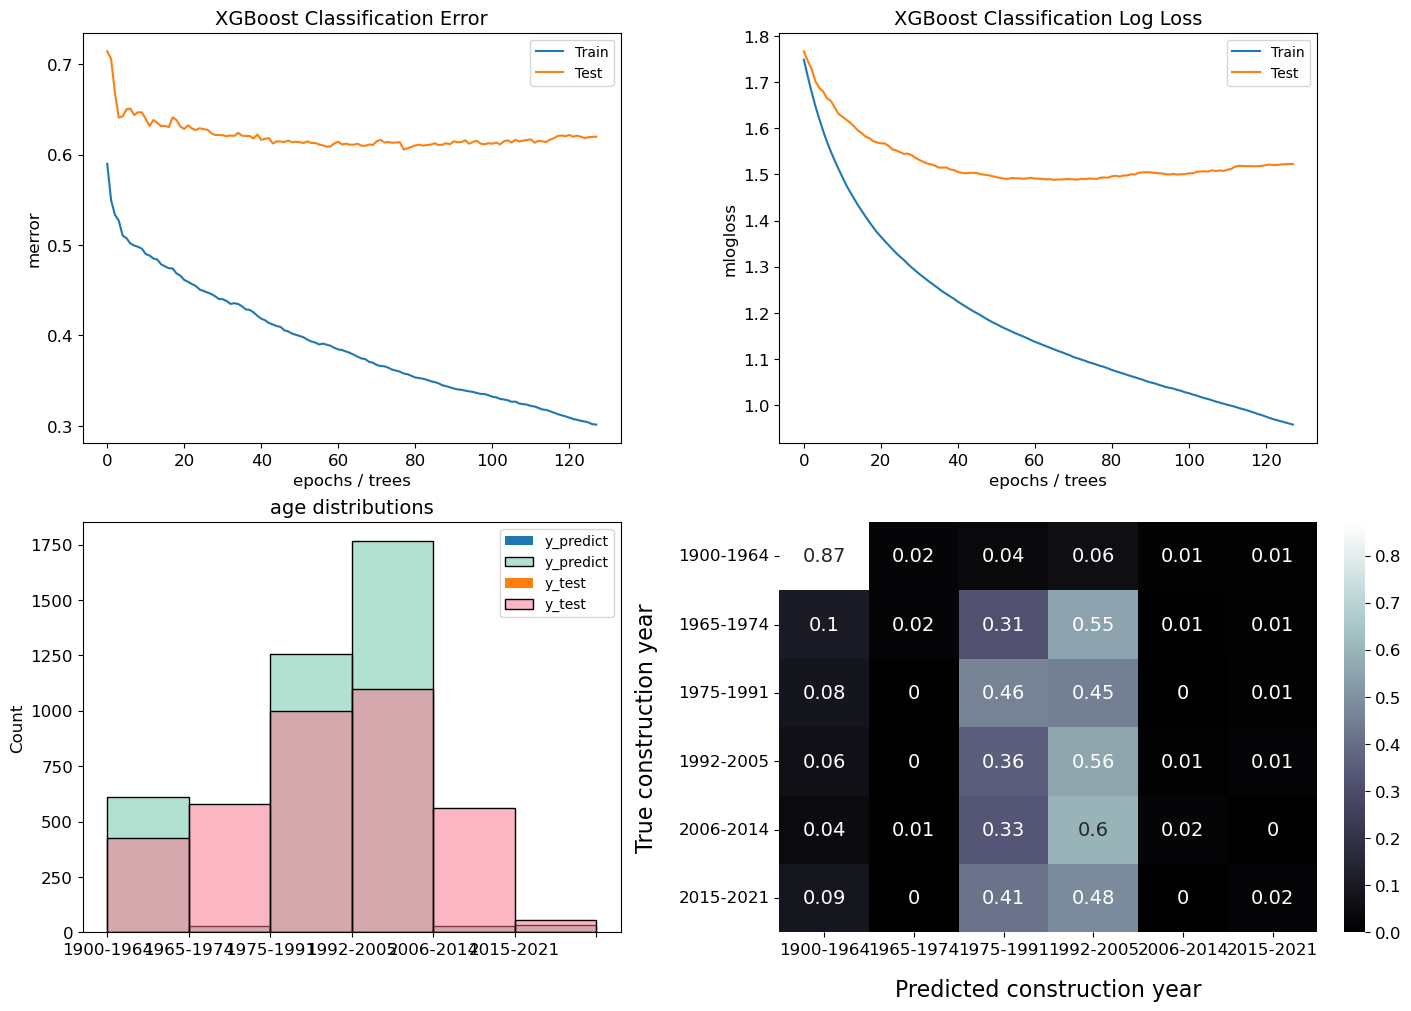

2022-11-27 16:37:40,915 | INFO : Generated bins: [1900, 1965, 1975, 1992, 2006, 2015, 2022]
2022-11-27 16:37:40,916 | INFO : Generated bins with the following labels: ['1900-1964', '1965-1974', '1975-1991', '1992-2005', '2006-2014', '2015-2021']


Train: Spain, Test: France


2022-11-27 16:37:41,230 | INFO : Dataset length: 247520
2022-11-27 16:37:41,239 | INFO : Dataset allocated memory: 262 MB
2022-11-27 16:37:41,273 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-d822dbb7.abort.
2022-11-27 16:37:41,274 | INFO : Training dataset length: 17673
2022-11-27 16:37:41,275 | INFO : Test dataset length: 4262
2022-11-27 16:37:41,276 | INFO : Test cities: ['Piera' 'Quintanilla de la Mata' 'San Martín del Castañar']
2022-11-27 16:37:41,325 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2022-11-27 16:37:41,355 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2022-11-27 16:37:41,417 | INFO : Training dataset length after preprocessing: 17191
2022-11-27 16:37:41,418 | INFO : Test dataset length after preprocessing: 3728
`early_stopping_rounds` in `fit` method is deprecated for better compatibility w

Classification report:
               precision    recall  f1-score  support
1900-1964      0.609477  0.871495  0.717308      428
1965-1974      0.387097  0.020654  0.039216      581
1975-1991      0.364865  0.458541  0.406375     1001
1992-2005      0.346939  0.556364  0.427374     1100
2006-2014      0.433333  0.023214  0.044068      560
2015-2021      0.030303  0.017241  0.021978       58
accuracy       0.394313  0.394313  0.394313        0
macro avg      0.362002  0.324585  0.276053     3728
weighted avg   0.396203  0.394313  0.330643     3728
Cohen’s kappa: 0.1906
Matthews correlation coefficient (MCC): 0.2025


FixedFormatter should only be used together with FixedLocator


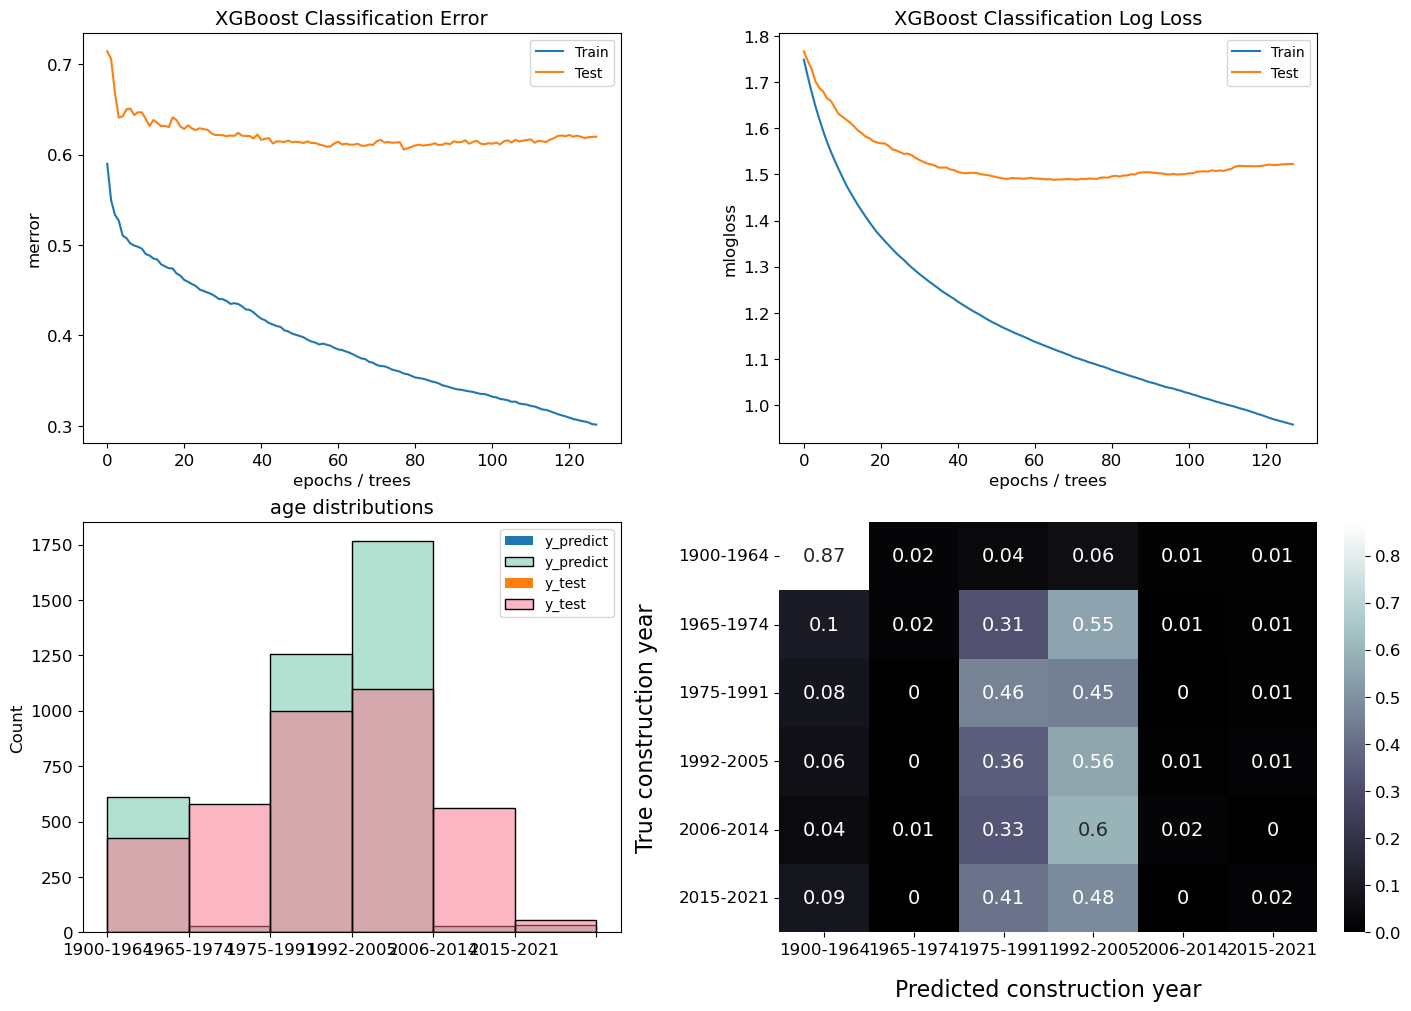

2022-11-27 16:37:47,381 | INFO : Generated bins: [1900, 1965, 1975, 1992, 2006, 2015, 2022]
2022-11-27 16:37:47,382 | INFO : Generated bins with the following labels: ['1900-1964', '1965-1974', '1975-1991', '1992-2005', '2006-2014', '2015-2021']


Train: Spain, Test: Netherlands


2022-11-27 16:37:47,695 | INFO : Dataset length: 247520
2022-11-27 16:37:47,705 | INFO : Dataset allocated memory: 262 MB
2022-11-27 16:37:47,740 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-ad26cca1.abort.
2022-11-27 16:37:47,740 | INFO : Training dataset length: 17673
2022-11-27 16:37:47,741 | INFO : Test dataset length: 4262
2022-11-27 16:37:47,743 | INFO : Test cities: ['Piera' 'Quintanilla de la Mata' 'San Martín del Castañar']
2022-11-27 16:37:47,796 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2022-11-27 16:37:47,827 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2022-11-27 16:37:47,890 | INFO : Training dataset length after preprocessing: 17191
2022-11-27 16:37:47,891 | INFO : Test dataset length after preprocessing: 3728
`early_stopping_rounds` in `fit` method is deprecated for better compatibility w

Classification report:
               precision    recall  f1-score  support
1900-1964      0.609477  0.871495  0.717308      428
1965-1974      0.387097  0.020654  0.039216      581
1975-1991      0.364865  0.458541  0.406375     1001
1992-2005      0.346939  0.556364  0.427374     1100
2006-2014      0.433333  0.023214  0.044068      560
2015-2021      0.030303  0.017241  0.021978       58
accuracy       0.394313  0.394313  0.394313        0
macro avg      0.362002  0.324585  0.276053     3728
weighted avg   0.396203  0.394313  0.330643     3728
Cohen’s kappa: 0.1906
Matthews correlation coefficient (MCC): 0.2025


FixedFormatter should only be used together with FixedLocator


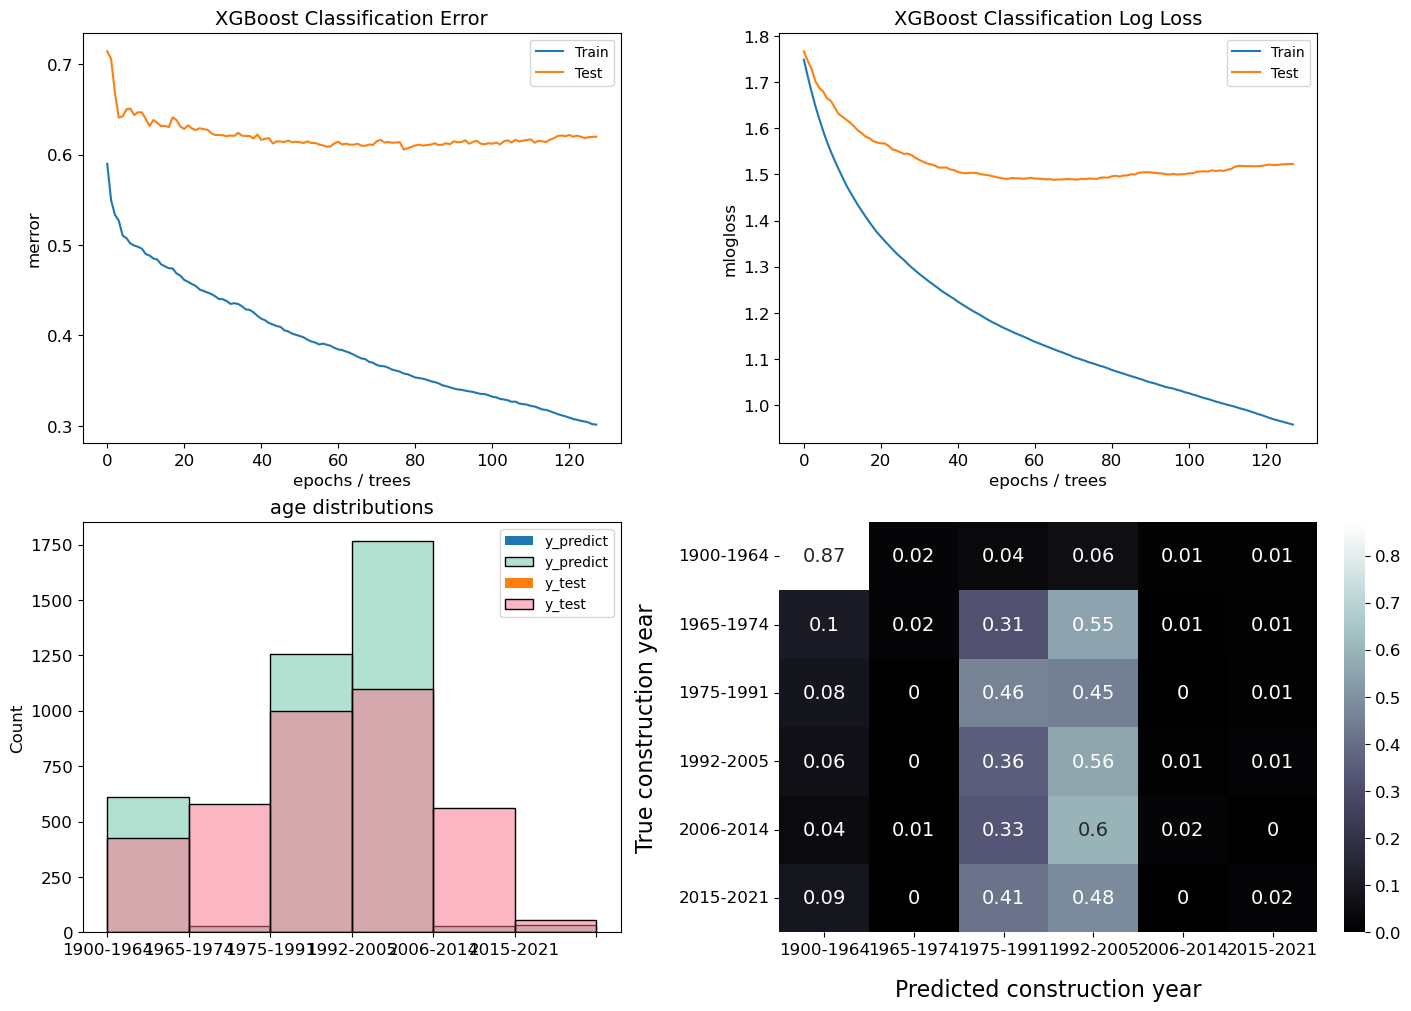

In [42]:
for train_country, test_country in itertools.permutations(list(config),2):
    print(f"Train: {train_country}, Test: {test_country}")
    test_training_split = lambda df: get_cross_country_split(
        df, config=config, test_country=country, train_country=country
    )
    classifier = AgeClassifier(
        model=XGBClassifier(**xgb_model_params),
        df=df.copy(),
        test_training_split=test_training_split,
        preprocessing_stages=[pp.remove_outliers],
        hyperparameters=xgb_hyperparams,
        mitigate_class_imbalance=True,
        bins=tabula_nl_bins,
    )
    classifier.evaluate()

#### Full Dataset

2022-11-27 16:38:11,927 | INFO : Generated bins: [1900, 1965, 1975, 1992, 2006, 2015, 2022]
2022-11-27 16:38:11,928 | INFO : Generated bins with the following labels: ['1900-1964', '1965-1974', '1975-1991', '1992-2005', '2006-2014', '2015-2021']


Train: ['France', 'Netherlands', 'Spain'] Test: France


2022-11-27 16:38:12,238 | INFO : Dataset length: 247520
2022-11-27 16:38:12,246 | INFO : Dataset allocated memory: 262 MB
2022-11-27 16:38:12,597 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-ee54d5d6.abort.
2022-11-27 16:38:12,597 | INFO : Training dataset length: 202718
2022-11-27 16:38:12,598 | INFO : Test dataset length: 10424
2022-11-27 16:38:12,599 | INFO : Test cities: ['Oullins' 'Royat' 'Saint-Ciers-sur-Gironde']
2022-11-27 16:38:13,187 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2022-11-27 16:38:13,445 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2022-11-27 16:38:14,001 | INFO : Training dataset length after preprocessing: 193242
2022-11-27 16:38:14,002 | INFO : Test dataset length after preprocessing: 6994
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-l

Classification report:
               precision    recall  f1-score  support
1900-1964      0.460177  0.293785  0.358621     1416
1965-1974      0.145833  0.008997  0.016949      778
1975-1991      0.474926  0.318308  0.381155     2529
1992-2005      0.234104  0.295082  0.261080     1098
2006-2014      0.222016  0.565877  0.318910     1055
2015-2021      0.025547  0.059322  0.035714      118
accuracy       0.308264  0.308264  0.308264        0
macro avg      0.260434  0.256895  0.228738     6994
weighted avg   0.351794  0.308264  0.302011     6994
Cohen’s kappa: 0.1307
Matthews correlation coefficient (MCC): 0.1383


FixedFormatter should only be used together with FixedLocator


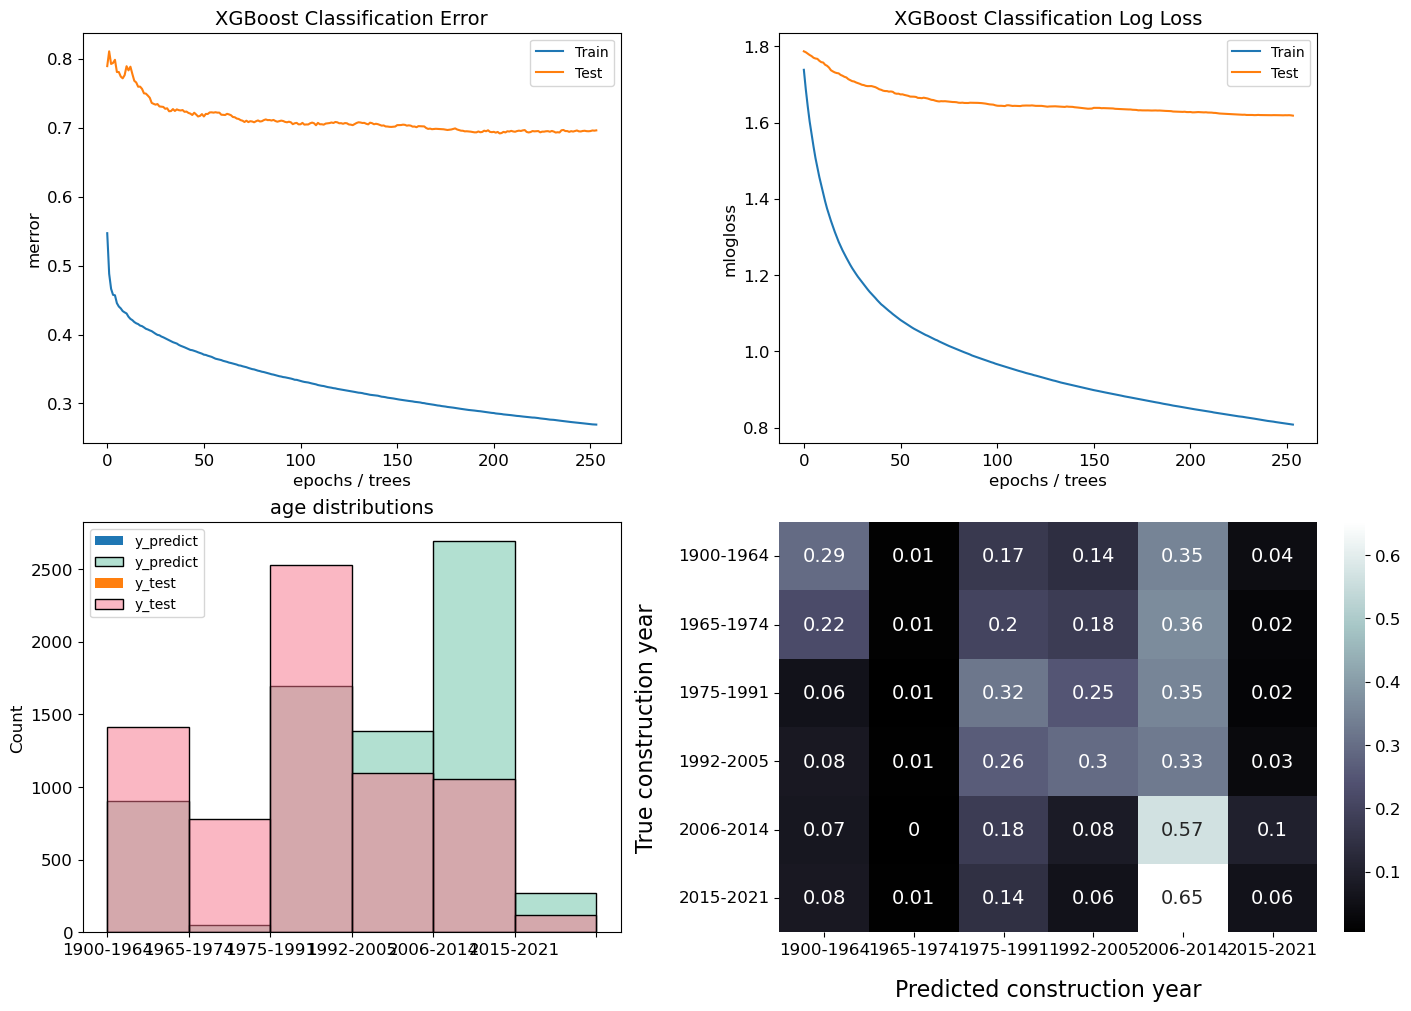

2022-11-27 16:39:06,269 | INFO : Generated bins: [1900, 1965, 1975, 1992, 2006, 2015, 2022]
2022-11-27 16:39:06,270 | INFO : Generated bins with the following labels: ['1900-1964', '1965-1974', '1975-1991', '1992-2005', '2006-2014', '2015-2021']


Train: ['France', 'Netherlands', 'Spain'] Test: Netherlands


2022-11-27 16:39:06,601 | INFO : Dataset length: 247520
2022-11-27 16:39:06,610 | INFO : Dataset allocated memory: 262 MB
2022-11-27 16:39:06,999 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-916bd22b.abort.
2022-11-27 16:39:07,000 | INFO : Training dataset length: 202718
2022-11-27 16:39:07,001 | INFO : Test dataset length: 30116
2022-11-27 16:39:07,003 | INFO : Test cities: ['Dronten' 'Jacobswoude' 'Renkum']
2022-11-27 16:39:07,614 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2022-11-27 16:39:07,886 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2022-11-27 16:39:08,570 | INFO : Training dataset length after preprocessing: 193242
2022-11-27 16:39:08,571 | INFO : Test dataset length after preprocessing: 29901
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use 

Classification report:
               precision    recall  f1-score  support
1900-1964      0.508434  0.238553  0.324740     3538
1965-1974      0.399933  0.535784  0.457997     6665
1975-1991      0.501962  0.247102  0.331175     9316
1992-2005      0.319015  0.246086  0.277845     6579
2006-2014      0.189472  0.474068  0.270738     3432
2015-2021      0.018797  0.053908  0.027875      371
accuracy       0.333868  0.333868  0.333868        0
macro avg      0.322936  0.299250  0.281728    29901
weighted avg   0.397870  0.333868  0.336248    29901
Cohen’s kappa: 0.1759
Matthews correlation coefficient (MCC): 0.1836


FixedFormatter should only be used together with FixedLocator


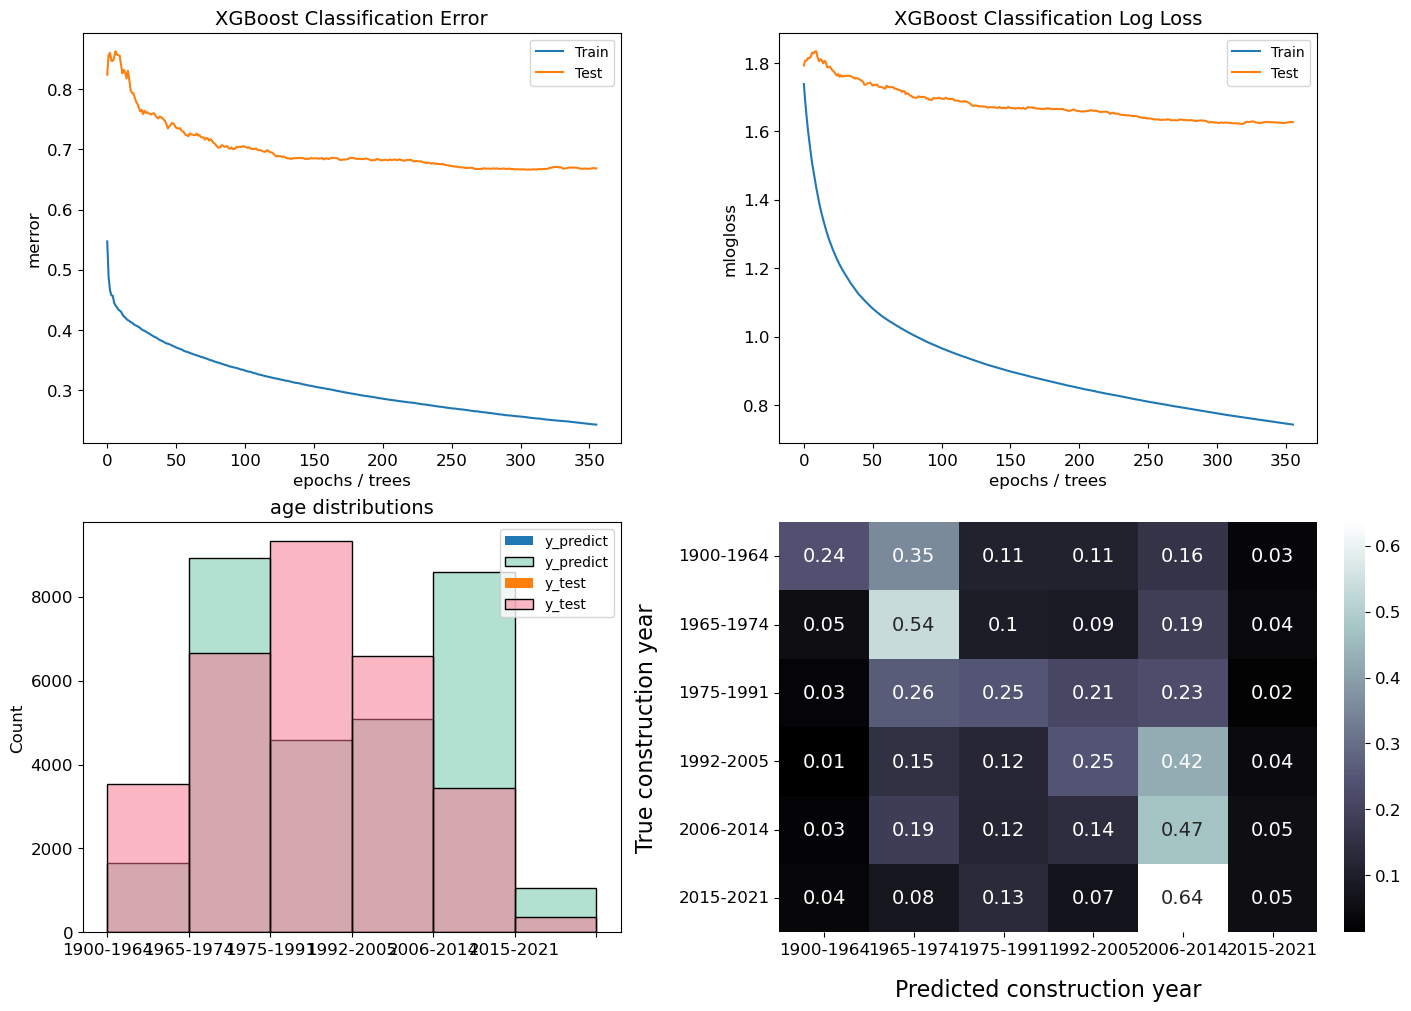

2022-11-27 16:40:21,447 | INFO : Generated bins: [1900, 1965, 1975, 1992, 2006, 2015, 2022]
2022-11-27 16:40:21,448 | INFO : Generated bins with the following labels: ['1900-1964', '1965-1974', '1975-1991', '1992-2005', '2006-2014', '2015-2021']


Train: ['France', 'Netherlands', 'Spain'] Test: Spain


2022-11-27 16:40:21,796 | INFO : Dataset length: 247520
2022-11-27 16:40:21,805 | INFO : Dataset allocated memory: 262 MB
2022-11-27 16:40:22,217 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs\local-2e861183.abort.
2022-11-27 16:40:22,217 | INFO : Training dataset length: 202718
2022-11-27 16:40:22,218 | INFO : Test dataset length: 4262
2022-11-27 16:40:22,219 | INFO : Test cities: ['Piera' 'Quintanilla de la Mata' 'San Martín del Castañar']
2022-11-27 16:40:22,805 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2022-11-27 16:40:23,113 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2022-11-27 16:40:23,741 | INFO : Training dataset length after preprocessing: 193242
2022-11-27 16:40:23,742 | INFO : Test dataset length after preprocessing: 3728
`early_stopping_rounds` in `fit` method is deprecated for better compatibility

Classification report:
               precision    recall  f1-score  support
1900-1964      0.458387  0.836449  0.592225      428
1965-1974      0.045455  0.001721  0.003317      581
1975-1991      0.334129  0.139860  0.197183     1001
1992-2005      0.333759  0.712727  0.454625     1100
2006-2014      0.134228  0.035714  0.056417      560
2015-2021      0.000000  0.000000  0.000000       58
accuracy       0.349517  0.349517  0.349517        0
macro avg      0.217660  0.287745  0.217294     3728
weighted avg   0.268070  0.349517  0.264072     3728
Cohen’s kappa: 0.1360
Matthews correlation coefficient (MCC): 0.1570


FixedFormatter should only be used together with FixedLocator


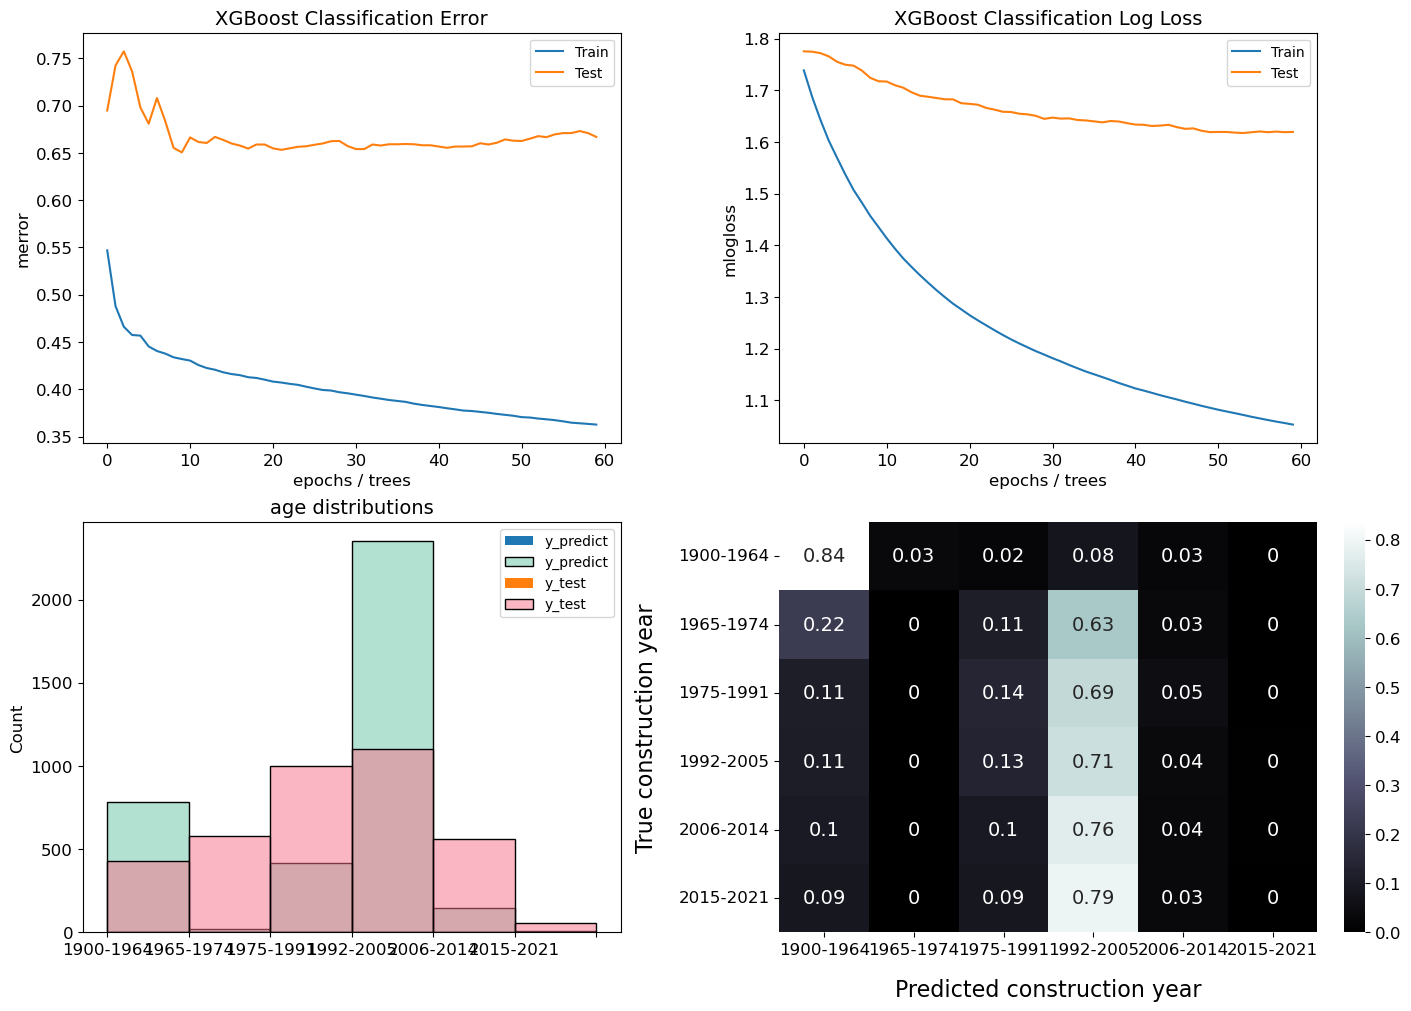

In [44]:
for country in config:
    print(f"Train: {list(config)} Test: {country}")
    test_training_split = lambda df: get_cross_country_split(
        df, config=config, test_country=country
    )
    classifier = AgeClassifier(
        model=XGBClassifier(**xgb_model_params),
        df=df.copy(),
        test_training_split=test_training_split,
        preprocessing_stages=[pp.remove_outliers],
        hyperparameters=xgb_hyperparams,
        mitigate_class_imbalance=True,
        bins=tabula_nl_bins,
    )
    classifier.evaluate()